# Health Insurance Cross-Sell

# 0.0 Solution Planning (IOT)

## Input

1 - Identificar se o cliente está ou não interessado no seguro de automóvel

2 - Dados da pesquisa com cerca de 380 mil clientes

## Output

1 - Principais Insights sobre os atributos mais relevantes de clientes interessados em adquirir um seguro de automóvel.

2 - Qual a porcentagem de clientes interessados em adquirir um seguro de automóvel, o time de vendas conseguirá contatar fazendo 20.000 ligações?

3- E se a capacidade do time de vendas aumentar para 40.000 ligações, qual a porcentagem de clientes interessados em adquirir um seguro de automóvel o time de vendas conseguirá contatar?

4 - Quantas ligações o time de vendas precisa fazer para contatar 80% dos clientes interessados em adquirir um seguro de automóvel?

## Tasks

1 - Explorar os Dados usando ferramentas e testes Estatísticos com o objetivo de encontrar inconsistências dos dados e tratar possíveis dados faltantes.

2 - Levantar Hipóteses sobre as características de transações legítimas e fraudulentas.

3 - Preparar os Dados para que os Algoritmos Estatísticos ou de Machine Learning sejam capazes de aprender a tarefa.

4 - Escrever vários algoritmos Classificadores.

5 - Contabilizar a Performance do Modelo de Machine Learning e transforme em Performance de Negócio.

6 - Desenvolver uma API que retorne um “Score de Propensão” de compra para cada cliente, ou seja, uma probabilidade do cliente estar interessado em comprar um seguro de automóvel.

7 - Gerar um Relatório respondendo às perguntas de negócio.



# 0.0 IMPORTS  

In [1]:
import warnings
import inflection
import pickle
import pandas       as pd
import seaborn      as sns
import scipy.stats  as ss
import scikitplot   as skplt
 
from IPython.display import HTML
from IPython.display import Image

import boruta  as bt
import xgboost as xgb

from sklearn  import metrics         as m
from sklearn  import preprocessing   as pp
from sklearn  import model_selection as ms
from sklearn  import ensemble        as en
from sklearn  import neighbors       as nh
from sklearn  import linear_model    as lm
from lightgbm import LGBMClassifier

from imblearn.combine        import SMOTETomek
from sklearn.model_selection import StratifiedShuffleSplit as sss
from sklearn.metrics         import precision_score, recall_score, accuracy_score, balanced_accuracy_score





## 0.2 Helper Functions

In [2]:
warnings.filterwarnings('ignore')

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()
    
def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0,chi2 - (k - 1) * (r - 1) / (n - 1))
    
    kcorr = k - (k - 1) ** 2/ (n - 1) 
    rcorr = r - (r - 1) ** 2/ (n - 1) 
    
    v = np.sqrt( (chi2corr / n) / (min (kcorr - 1,rcorr - 1)))
    return v   

def corr_cramer_v(categorical_attributes):
    cat_attributes_list = categorical_attributes.columns.tolist()

    corr_dict = {}

    for i in range(len(cat_attributes_list)):
        corr_list = []
        for j in range(len(cat_attributes_list)):
            ref  = cat_attributes_list[i]
            feat = cat_attributes_list[j]
            corr = cramer_v(categorical_attributes[ref],categorical_attributes[feat])
            corr_list.append(corr)
        corr_dict[ref] = corr_list
    return corr_dict
    
    
    
# Function to plot a dataframe with percentage of categorical columns values
def df_percent( col_name ):
    a = pd.DataFrame( cat_attributes[col_name].value_counts() ).reset_index()
    b = pd.DataFrame( cat_attributes[col_name].value_counts( normalize=True )*100 ).reset_index()
    df = pd.merge( a, b, how='left', on='index' )
    df.columns = [col_name,'absolute', 'percentage']
    return df

# precision @K
def precision_at_k( data, k = 20000 ):
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']

# Recall @K
def recall_at_k( data, k = 20000 ):
    # reset index
    data = data.reset_index( drop = True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']




def cross_validation(model, x_train, y_train, k, data, Verbose = True):
    
    kfold = ms.StratifiedKFold(n_splits=k, shuffle=True, random_state=28)
    precision_list = []
    recall_list = []
    precision_k_list = []
    recall_k_list = []
    accuracy_list = []
    i=1

    for train_cv, val_cv in kfold.split(x_train, y_train):
        
        if Verbose == True:
            
            print(f'Fold Number {i}/{k}')
            
        else:
            pass
        
        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]
        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]

        model_fit = model.fit(x_train_fold, y_train_fold.values.ravel())
        yhat = model.predict_proba(x_val_fold)
        yhat_1 = model.predict(x_val_fold)
        
        
        data = x_val_fold.copy()
        data['response'] = y_val_fold.copy()
        data['score'] = yhat[:, 1].tolist()
        data = data.sort_values('score', ascending=False)

        precision_k = precision_at_k(data, k = 20000)
        precision_k_list.append(precision_k,)
        
        recall_k = recall_at_k(data, k = 20000)
        recall_k_list.append(recall_k)
        
        precision = precision_score(y_val_fold, yhat_1)
        precision_list.append(precision)
        
        recall = recall_score(y_val_fold, yhat_1)
        recall_list.append(recall)

        accuracy = accuracy_score(y_val_fold, yhat_1)
        accuracy_list.append(accuracy)
            
        
        i+=1
        
    df = pd.DataFrame({'Model Name': type(model).__name__, 
                       'Accuracy Mean': np.mean(accuracy_list).round(4),
                       'Precision Mean': np.mean(precision_list).round(4),
                       'Precision STD': np.std(precision_list).round(4),
                       'Recall Mean': np.mean(recall_list).round(4),
                       'Recall STD': np.std(recall_list).round(4),
                       'Precision@K Mean': np.mean(precision_k_list).round(4), 
                       'Precision@K STD': np.std(precision_k_list).round(4),
                       'Recall@K Mean': np.mean(recall_k_list).round(4), 
                       'Recall@K STD': np.std(recall_k_list).round(4)}, index = [0])

    return df




Populating the interactive namespace from numpy and matplotlib


## 0.3 Load Data

In [4]:
df_raw = pd.read_csv( '../data/raw/train.csv' )

In [5]:
df_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# 1.0 DATA DESCRIPTON

In [6]:
# create a copy
df1 = df_raw.copy()

In [7]:
df1.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


**ID:** Customer's identification

**Gender**: Customer's Gender

**Age**: Customer's Age

**Driving License**: 0 for customer without driving license and 1 customer with driving license

**Region Code**: Customer's region code

**Previously Insured**: 0, the client does not have car insurance and 1, the client already has car insurance.

**Vehicle Age**: Vehicle Age

**Vehicle Damage**: 0, customer has never had their vehicle damaged in the past and 1, customer has had their vehicle damaged in the past.

**Anual Premium**: Amount the customer paid the company for annual health insurance.

**Policy sales channel:**: Anonymous code for the customer contact channel.

**Vintage**: number of days the customer joined the company through the purchase of health insurance.

**Response**: 0, the customer is not interested and 1, the customer is interested.

## 1.1 Rename Columns

In [8]:
df1.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [9]:
old_columns = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response']

snakecase = lambda x: inflection.underscore( x )

new_columns = list( map( snakecase, old_columns ) )

# rename
df1.columns = new_columns
df1.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

## 1.2 Data DImension

In [10]:
print( 'Number of Rows: {}'.format(df1.shape[0]) )
print( 'Number of Columns: {}'.format(df1.shape[1]) )

Number of Rows: 381109
Number of Columns: 12


## 1.3 Data Types

In [11]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

### 1.3.1 Changing Data Types

## 1.4 Check NA

In [12]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## ~~1.5 Fill NA~~

No NA values were found

## 1.6 Descriptive Statistical

In [13]:
# Isolate numerical and categorical variables
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( include=['object'] )

### 1.6.1 Numerical Attributes

In [14]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min , max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concat
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['Atribbutes', 'Min', 'Max', 'Range', 'Mean', 'Median', 'Std', 'Skew', 'Kurtosis']
m

,Atribbutes,Min,Max,Range,Mean,Median,Std,Skew,Kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


### 1.6.2 Categorical Attributes

In [15]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

In [16]:
df_percent( 'gender' )

,gender,absolute,percentage
0,Male,206089,54.07613
1,Female,175020,45.92387


In [17]:
df_percent( 'vehicle_age' )

,vehicle_age,absolute,percentage
0,1-2 Year,200316,52.561341
1,< 1 Year,164786,43.238549
2,> 2 Years,16007,4.200111


In [18]:
df_percent( 'vehicle_damage' )

,vehicle_damage,absolute,percentage
0,Yes,192413,50.487656
1,No,188696,49.512344


# 2.0 DATA ENGINEERING

In [19]:
df2 = df1.copy()

## 2.1 Hypotheses

### 2.1.1 MindMap

In [20]:
Image( url= "../images/Health_Insurance.png" )

### 2.1.1 Hypotheses list

1 - Clientes mais jovens não assinam seguro automovel

2 - Pessoas mais jovens tem carros mais danificados

3 - Mulheres assinam mais seguros que homens

4 - Pessoas mais velhas tem mais carteiras de motorista

5 - Homens tem carros com mais danos

6 - Carros mais novos tem menos danos

7 - Pessoas com carros mais populares assinam menos o seguro

8 - Pessoas que deixam o carro estacionado ao ar livre assinam mais o seguro

9 - Pessoas que pagam mais pelo seguro saúde tendem a assinar o seguro de automovel

## 2.2 Feature Engineering

In [21]:
# Create risk age variable
df2['risk_age'] = df2['age'].apply( lambda x: 'Yes' if x < 25 else 'No' )

# Vintage_month
# Separating vintage in months
df2['vintage_month'] = df2['vintage'].apply( lambda x: 'month' if  x <= 31 else 'quarter' if (x > 31 ) & (x <= 90) else 
                                            'semester' if (x > 90) & (x <= 180) else 'close to a year')
# premium_per_day (annual_premium/vintage)
df2['premium_per_day'] = round( df2['annual_premium'] / df2['vintage'], 2 )

# People by region
#df2['people_by_region'] = df2[['id','region_code']].groupby( 'region_code' ).count().reset_index()['id']

# mean annual premium per region
#aux = df2[['region_code', 'annual_premium']].groupby( 'region_code' ).mean().reset_index()['annual_premium']
#df2['mean_annual_premium_region'] = round(aux, 2)

In [22]:
df2.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,risk_age,vintage_month,premium_per_day
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1,No,close to a year,186.42
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0,No,close to a year,183.26
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1,No,month,1418.30
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0,Yes,close to a year,140.98
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0,No,quarter,705.03


In [23]:
df2.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
risk_age                0
vintage_month           0
premium_per_day         0
dtype: int64

# 3.0 VARIABLE SELECTION

In [24]:
df3 = df2.copy()

In [25]:
df3.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response', 'risk_age',
       'vintage_month', 'premium_per_day'],
      dtype='object')

* On the first CRISP cycle we use all features

# 4.0 EXPLORATORY DATA ANALYSIS

In [26]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

In [27]:
df4['response'].value_counts( normalize=True )*100

0    87.743664
1    12.256336
Name: response, dtype: float64

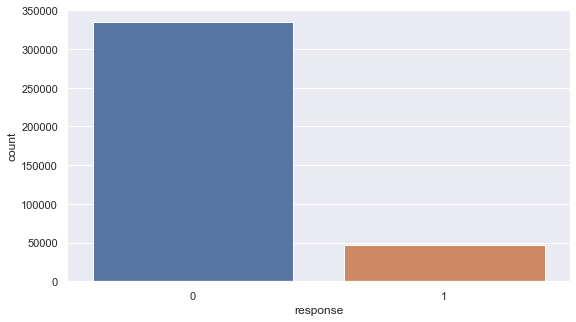

In [28]:
plt.figure( figsize=(9,5) )
sns.countplot( x='response', data=df4 );

 About **12,26%** of all customers have interest on vehicle insurance

### 4.1.3 Numerical Variables

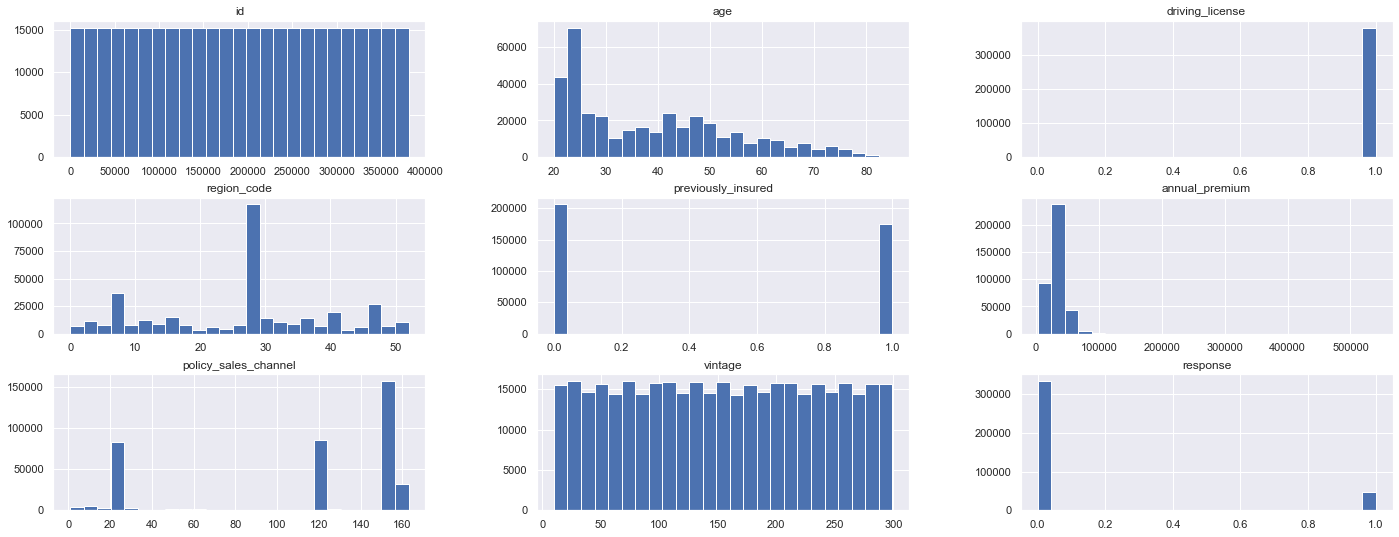

In [29]:
num_attributes.hist( bins=25 );

### 4.1.3 Categorical Variables

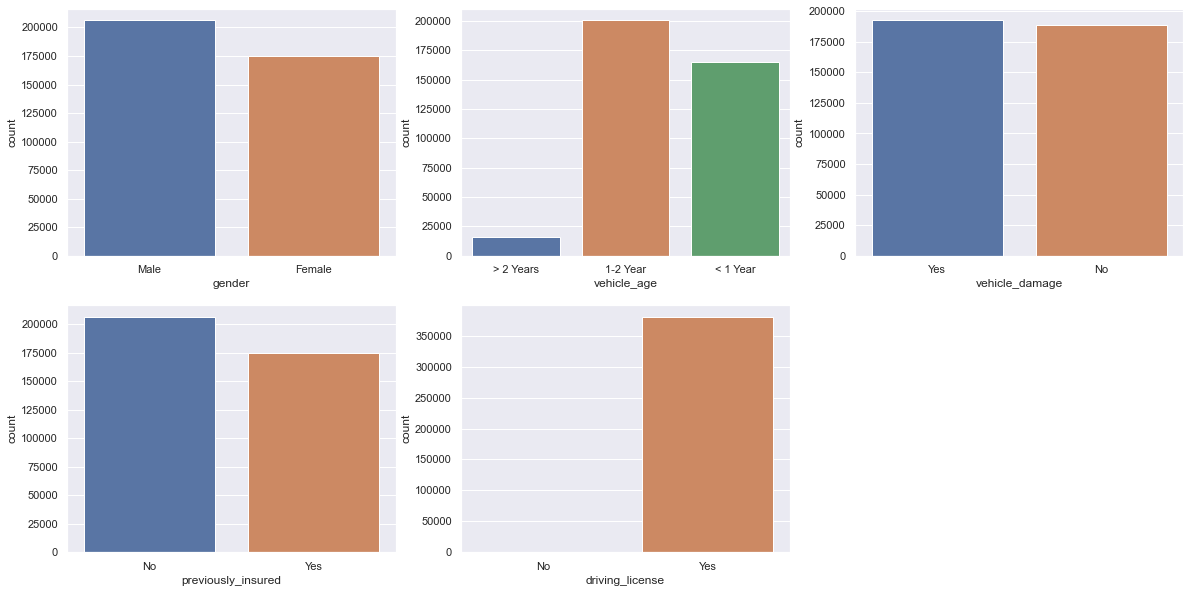

In [30]:
plt.figure( figsize=(20, 10) )


plt.subplot( 2, 3, 1 )
sns.countplot( x='gender', data=df4 );

plt.subplot( 2, 3, 2 )
sns.countplot( x='vehicle_age', data=df4 );

plt.subplot( 2, 3, 3 )
sns.countplot( x='vehicle_damage', data=df4 );

plt.subplot( 2, 3, 4 )
sns.countplot( x='previously_insured', data=df4 );
plt.xticks( [0,1],['No','Yes'] );

plt.subplot( 2, 3, 5 )
sns.countplot( x='driving_license', data=df4 );
plt.xticks( [0,1],['No','Yes'] );


## 4.2 Bivariate Analysis

In [31]:
# Changing 1 in yes and 0 in no to better visualization
df4['driving_license'] = df4['driving_license'].apply( lambda x: 'Yes' if x == 1 else 'No' )
df4['previously_insured'] = df4['previously_insured'].apply( lambda x: 'Yes' if x == 1 else 'No' )
df4['response'] = df4['response'].apply( lambda x: 'Yes' if x == 1 else 'No' )

1 - Pessoas com 40 anos ou mais tem mais interesse no seguro

2 - Pessoas mais jovens tem carros mais danificados

3 - Mulheres assinam mais seguros que homens

4 - Clientes na idade de risco assinam menos seguros

5 - Homens tem carros com mais danos

6 - Carros mais novos tem menos danos

7 - Pessoas com carros mais populares assinam menos o seguro

8 - Pessoas que deixam o carro estacionado ao ar livre assinam mais o seguro

9 - Pessoas que pagam mais pelo seguro saúde tendem a assinar o seguro de automovel

H5 Clientes que já tiveram seu veículo danificado tem maior probabilidade de adquirir seguro de automóvel.

### H1 - Pessoas com 30 anos ou mais tem mais interesse no seguro - TRUE

40336 pessoas com mais de 30 anos afirmaram ter interesse no seguro contra apenas 6374 pessoas com menos de 30 anos

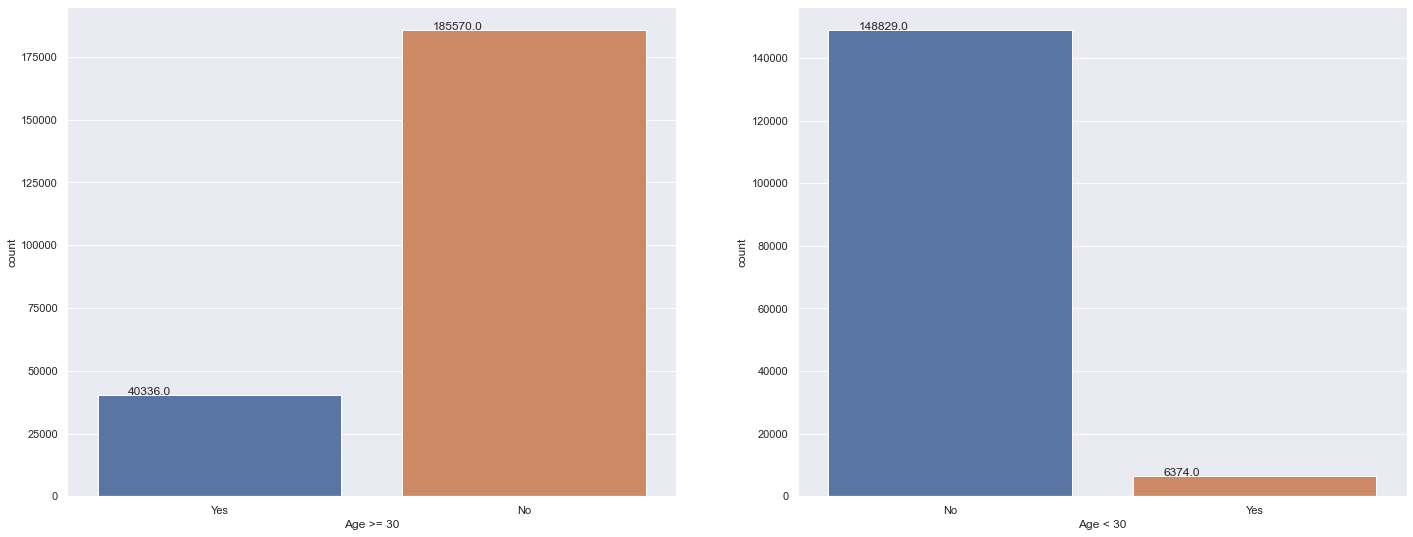

In [32]:
aux1 = df4[df4['age'] >= 30 ]
aux2 = df4[df4['age'] < 30]

plt.subplot( 1, 2, 1 )
ax = sns.countplot( x='response', data=aux1 );
plt.xlabel( 'Age >= 30' );

plt.subplot( 1, 2, 2 )
ax2 = sns.countplot( x='response', data=aux2 );
plt.xlabel( 'Age < 30' );

for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
        

for p in ax2.patches:
        ax2.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))       

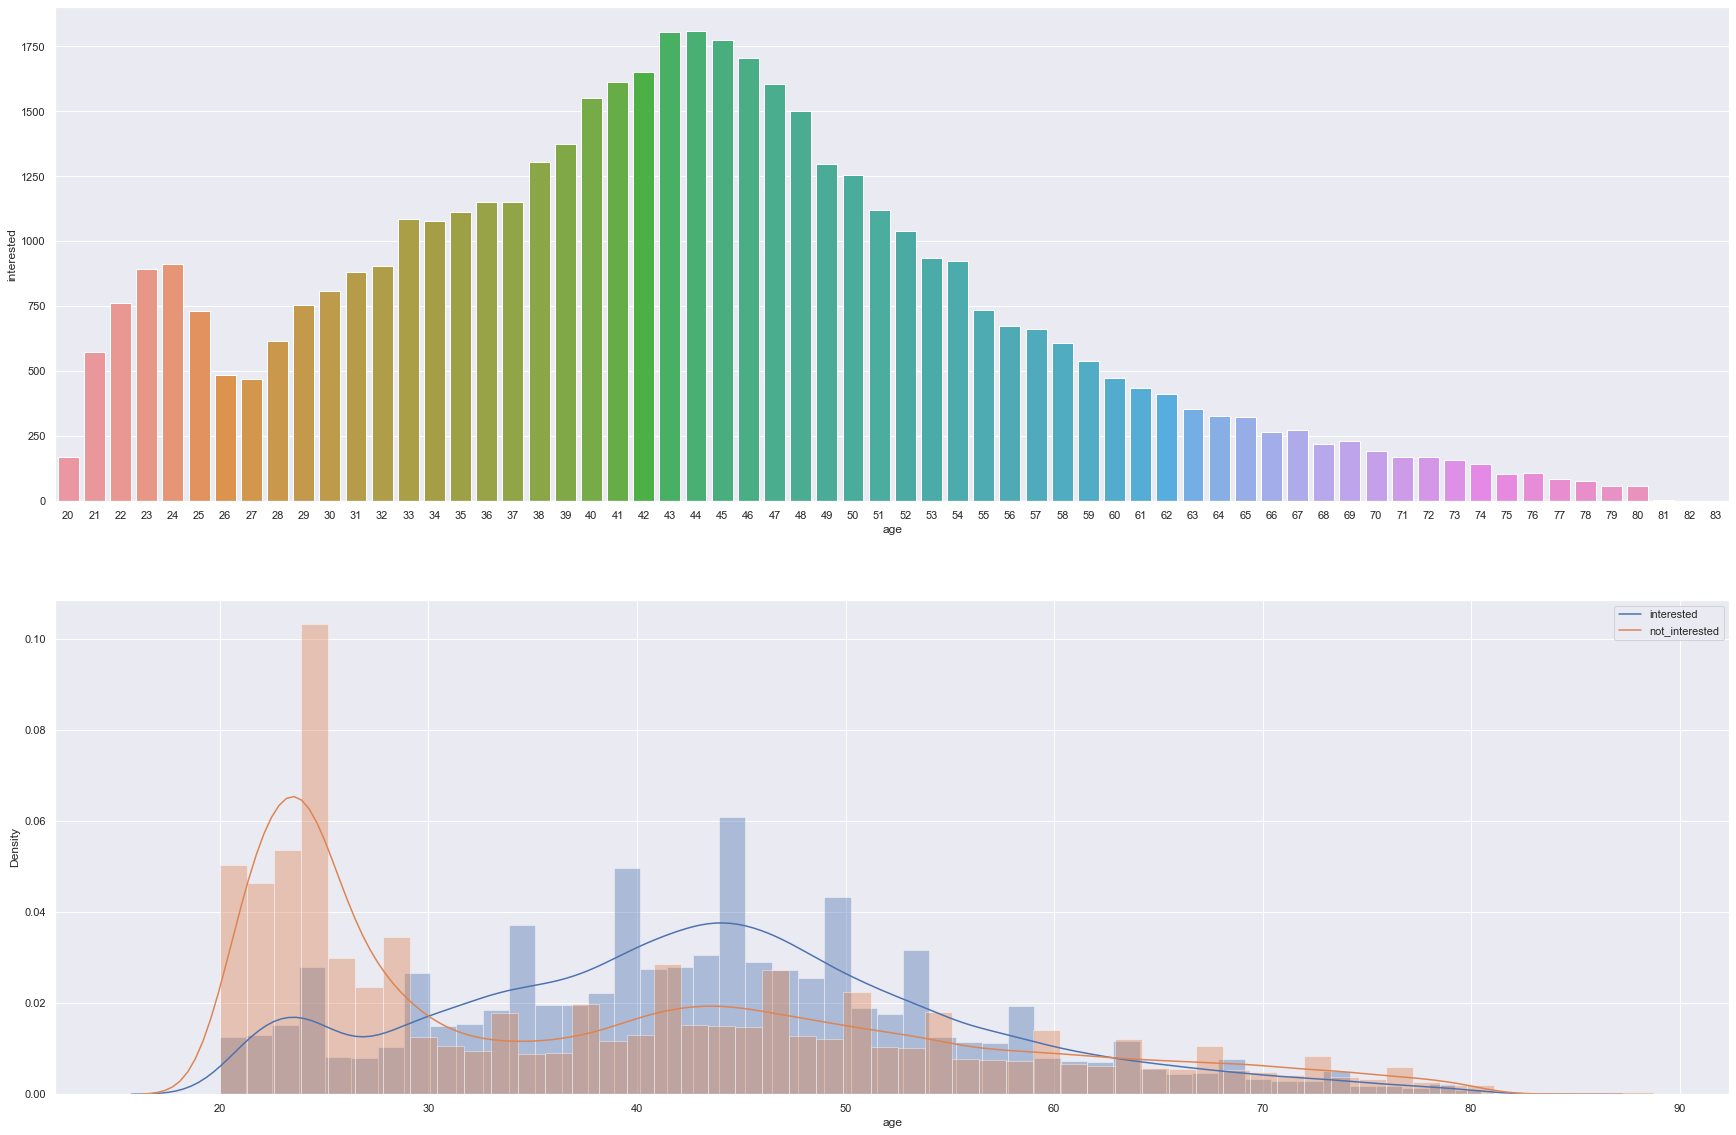

In [33]:
plt.figure( figsize=( 30, 20 ) )

plt.subplot( 2, 1, 1 )
a1 = df4[df4['response'] == 'Yes' ]
sns.countplot( x='age', data=a1 );
plt.ylabel( 'interested' );

plt.subplot( 2, 1, 2 )
sns.distplot( df4[df4['response'] == 'Yes' ]['age'] );
sns.distplot( df4[df4['response'] == 'No' ]['age'] );
plt.legend( ['interested', 'not_interested'] );

### H2 - Pessoas mais jovens tem carros mais danificados - TRUE

Idades entre 21 e 24 anos tiveram mais carros danificados

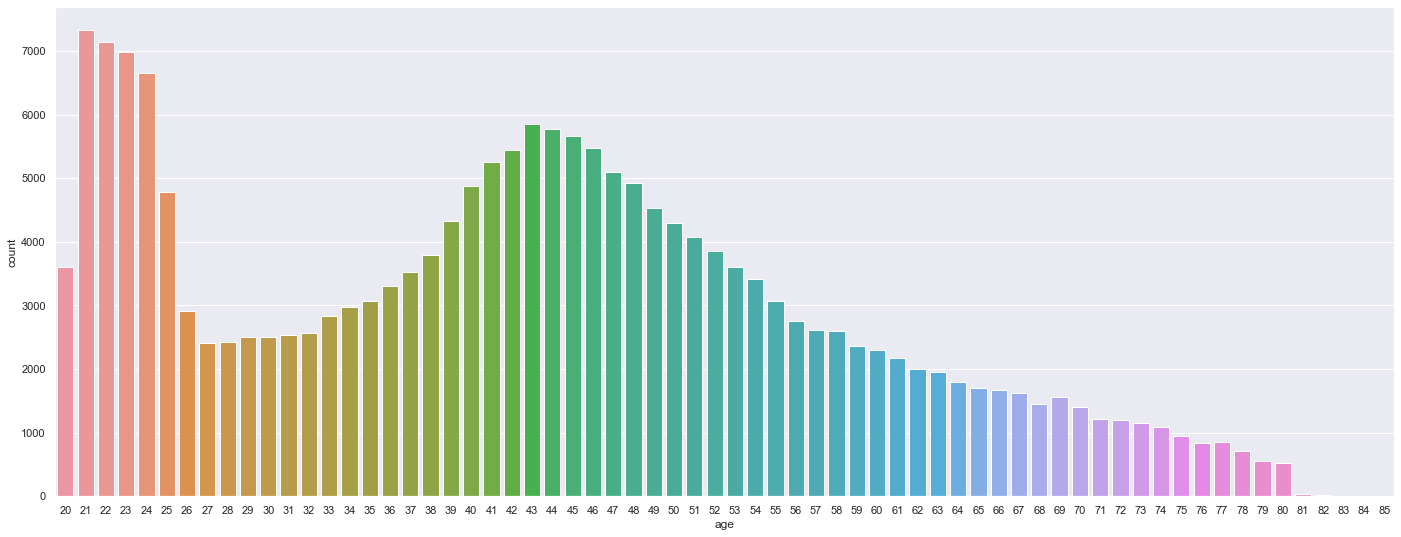

In [34]:
aux1 = df4[df4['vehicle_damage'] == 'Yes' ]

sns.countplot( x='age', data=aux1 );

### H3 - Mulheres têm mais interesse em assinar o seguro - False

**False**: Homens estão mais interessados no seguro do automóvel 

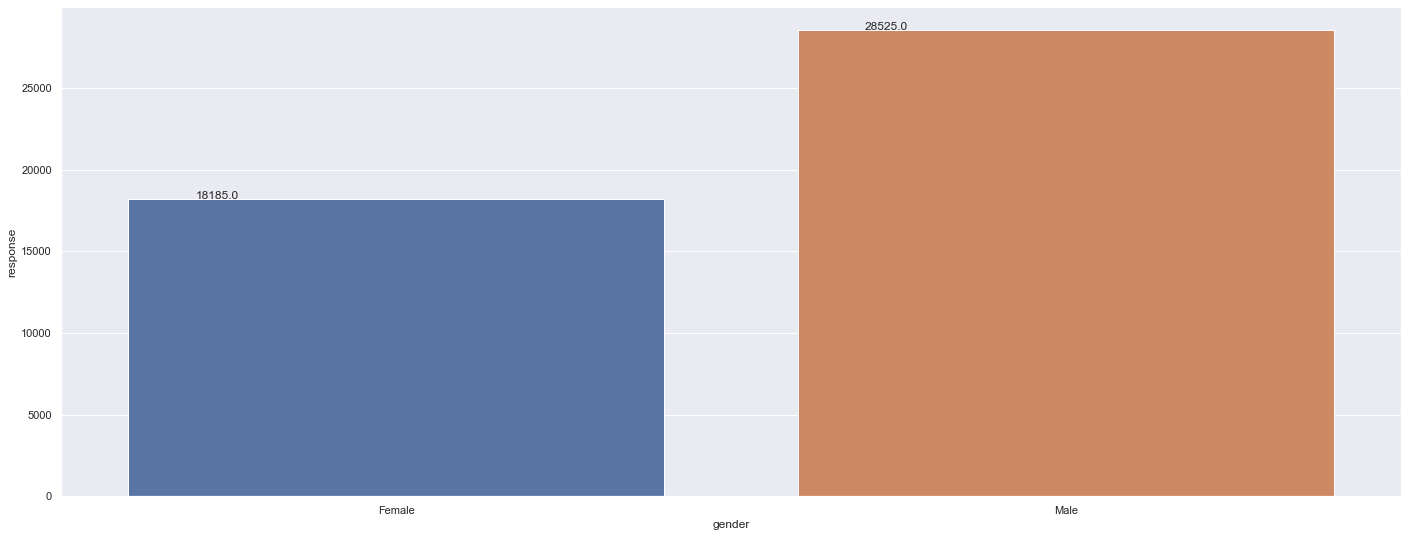

In [35]:
aux = df4[df4['response'] == 'Yes'][['gender', 'response']].groupby( 'gender' ).count().reset_index()
ax = sns.barplot( x='gender', y='response', data=aux )

for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))

### H4 - Clientes fora da idade de risco tem mais interesse em assinar  seguros - TRUE

**True**: 15,11% dos clientes fora da zona de risco têm interesse no seguro contra 3,53% dos que estão na zona de risco 

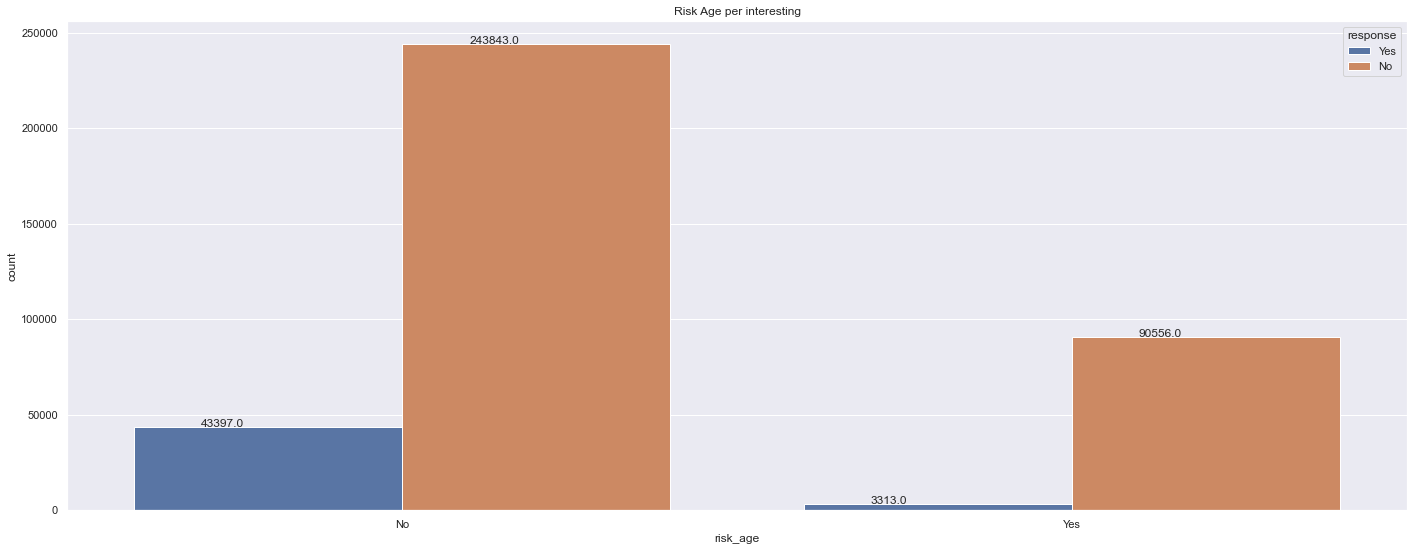

In [36]:
# risk_age/response
ax = sns.countplot(data=df4, x='risk_age', hue='response')
plt.title( 'Risk Age per interesting' );

for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))

### H5 - Homens tem carros com mais danos - TRUE

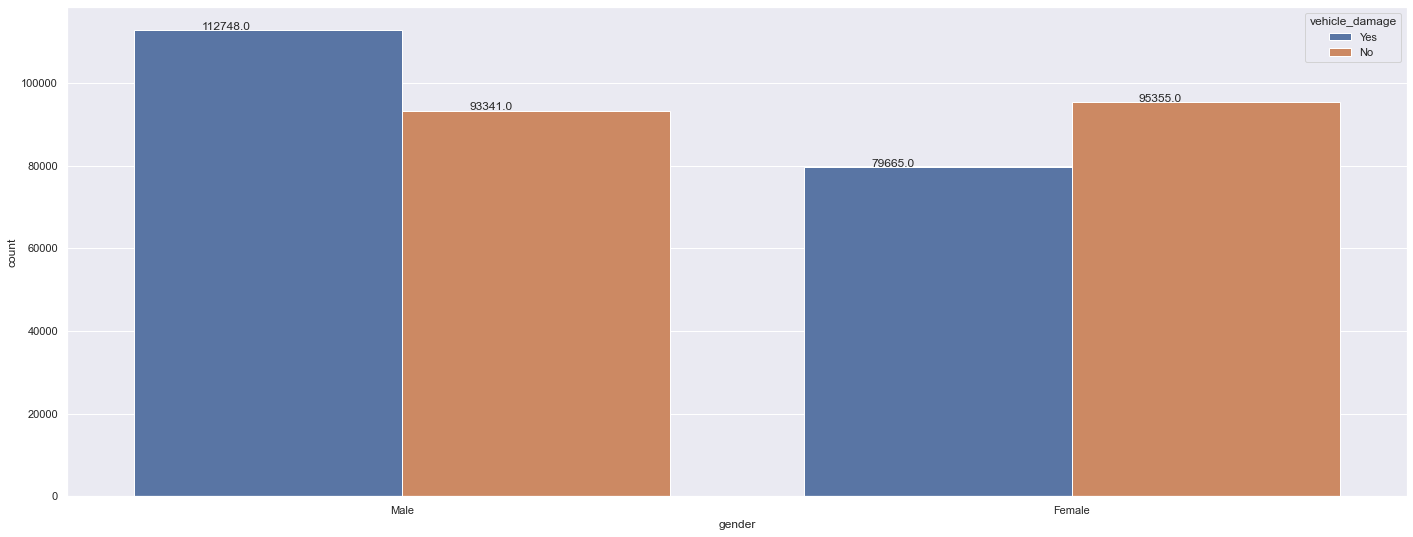

In [37]:
# Gender/vehicle_damage
ax = sns.countplot(data=df4, x='gender', hue='vehicle_damage', hue_order=[ 'Yes', 'No' ] )

for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))

### H6 - Carros mais velhos tem mais danos - FALSE

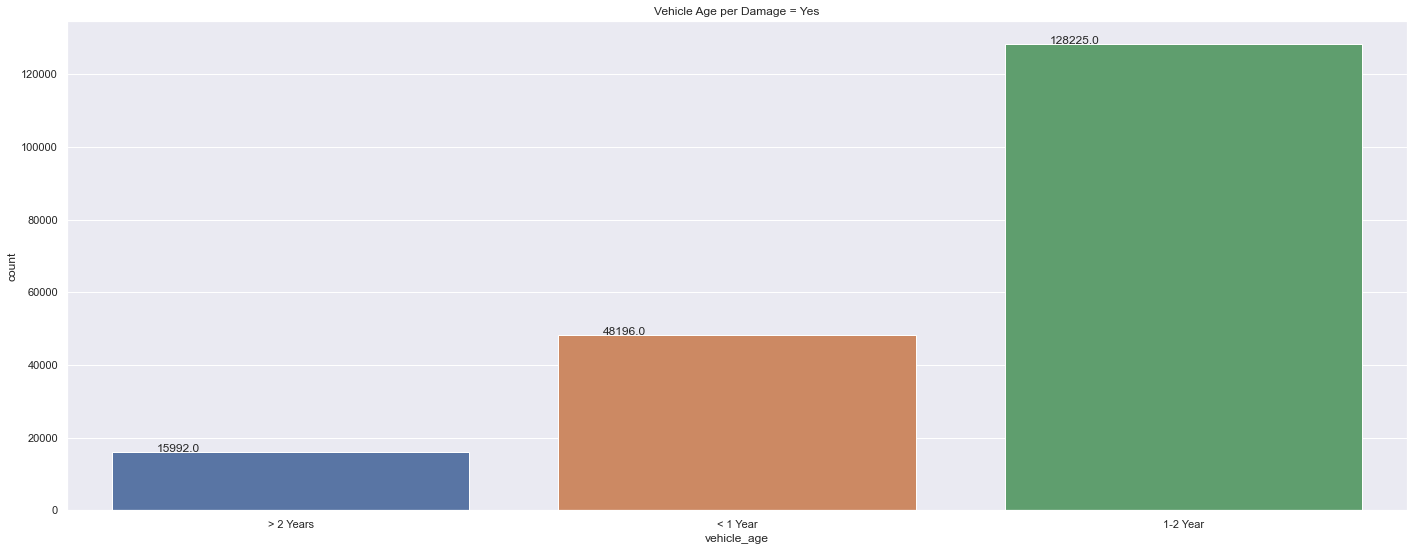

In [38]:
aux = df4.loc[df4['vehicle_damage'] == 'Yes']

ax = sns.countplot( x='vehicle_age', data=aux )
plt.title( 'Vehicle Age per Damage = Yes' );

for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))

### H7 - Pessoas que assinam o seguro de saúde a mais tempo tem mais chances de comprar o seguro de automovel - TRUE

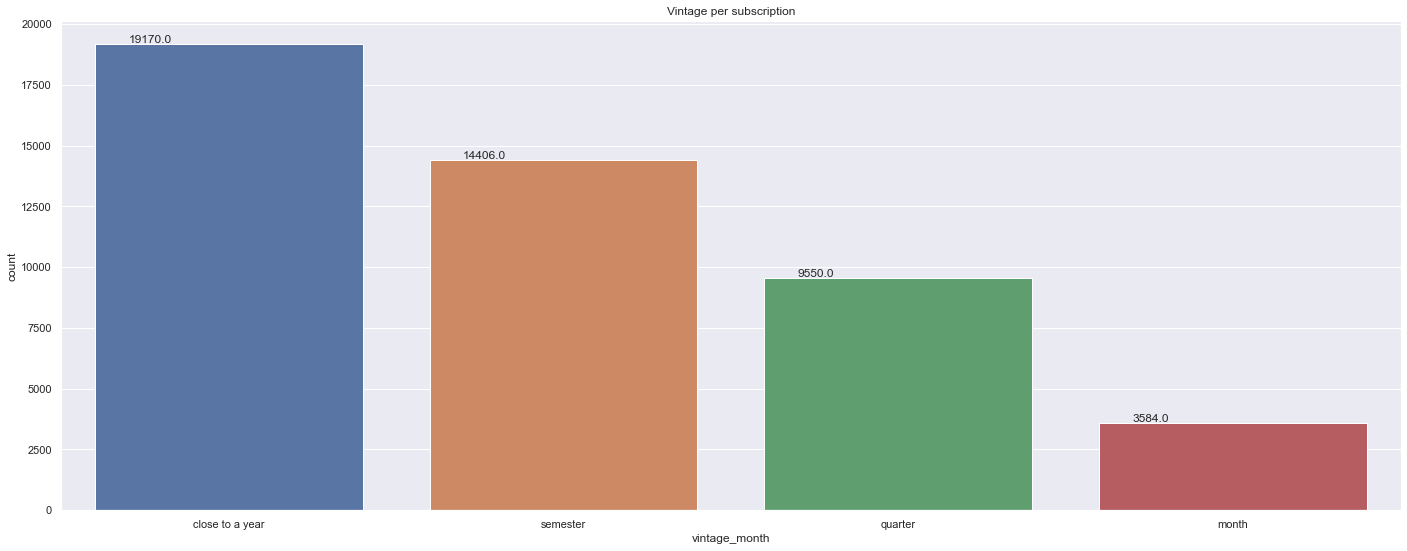

In [39]:
# Vintage_month/response
aux = df4[df4['response'] == 'Yes']

ax = sns.countplot( x='vintage_month',
              data = aux,
              order = aux['vintage_month'].value_counts().index );

plt.title( 'Vintage per subscription' );

for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))

### H8 - Pessoas que pagam mais pelo seguro saúde tendem a assinar o seguro de automovel 

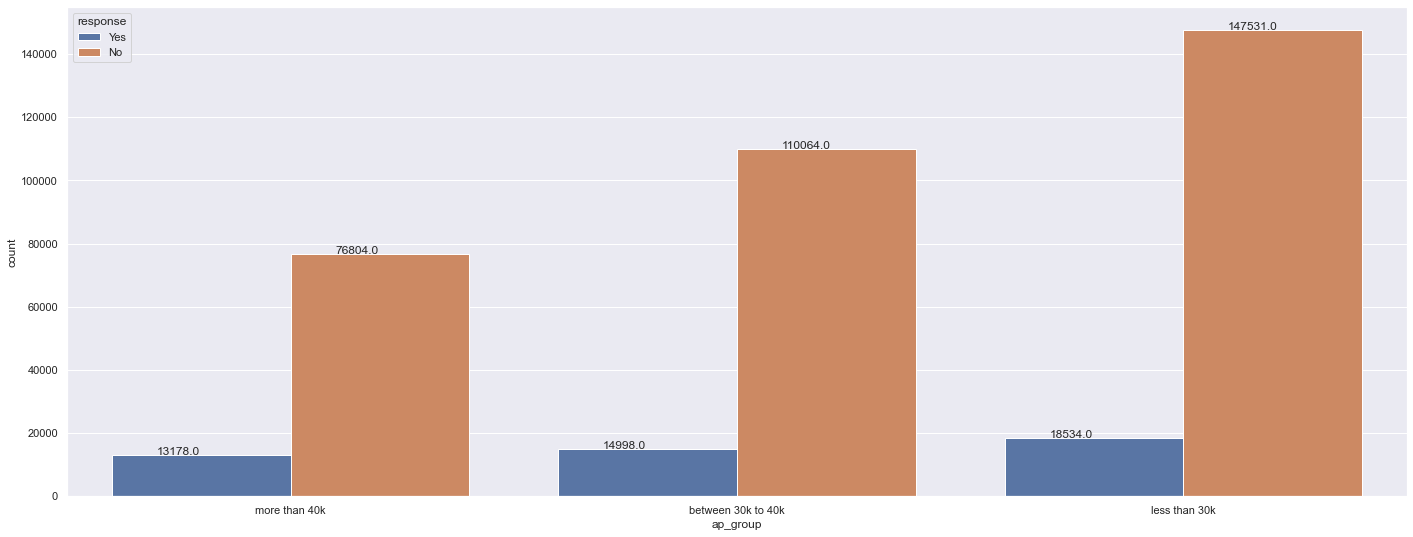

In [40]:
aux = df4.copy()
aux['ap_group'] = aux['annual_premium'].apply( lambda x: 'less than 30k' if x<30000 else 'more than 40k' if x>40000 else 'between 30k to 40k' )
ax = sns.countplot( x='ap_group', hue='response', data=aux );

for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))

## 4.3 Multivariate Analysis

### 4.3.1 Numerical Atributes

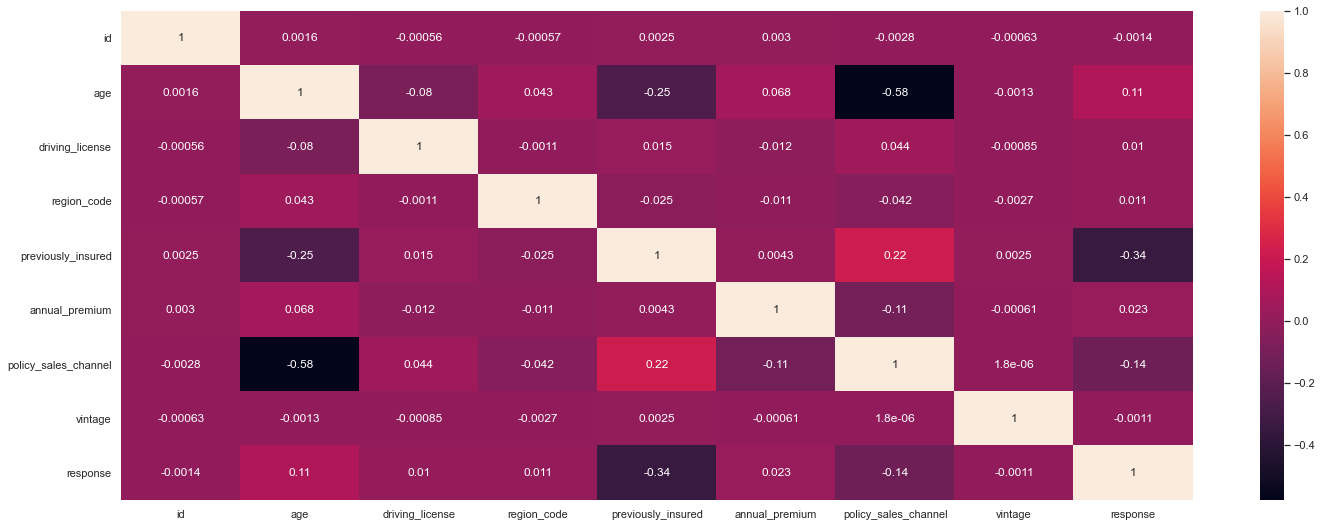

In [41]:
sns.heatmap( num_attributes.corr( method='pearson' ), annot=True );

In [42]:
a = df4.select_dtypes( include='object' )

In [43]:
a.head()

,gender,driving_license,previously_insured,vehicle_age,vehicle_damage,response,risk_age,vintage_month
0,Male,Yes,No,> 2 Years,Yes,Yes,No,close to a year
1,Male,Yes,No,1-2 Year,No,No,No,close to a year
2,Male,Yes,No,> 2 Years,Yes,Yes,No,month
3,Male,Yes,Yes,< 1 Year,No,No,Yes,close to a year
4,Female,Yes,Yes,< 1 Year,No,No,No,quarter


<AxesSubplot:>

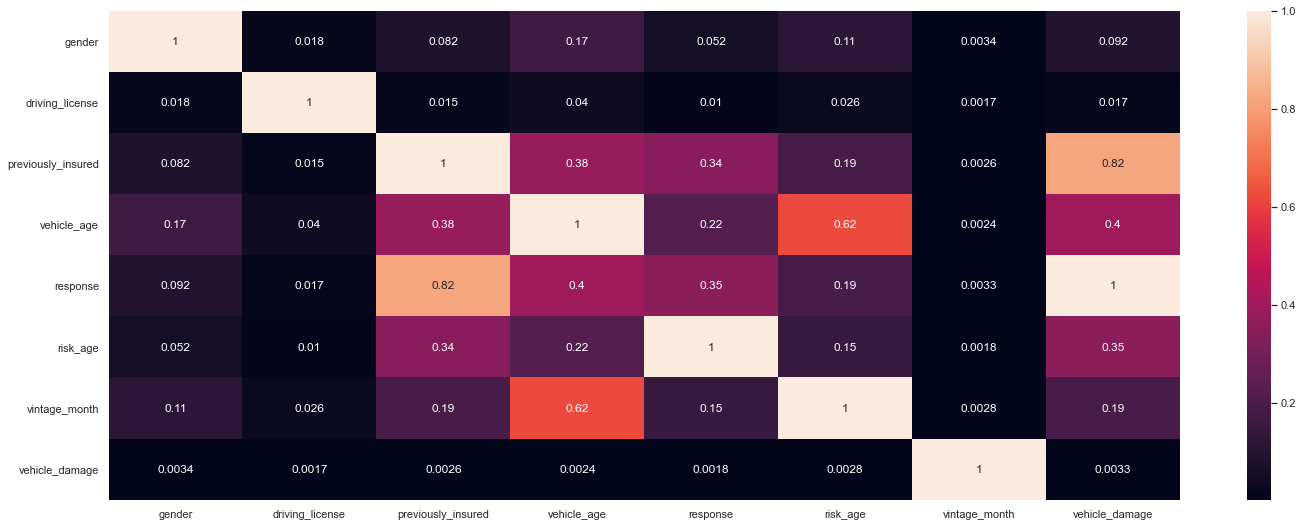

In [44]:
# Calculate cramer V
a1 = cramer_v( a['gender'], a['gender'] )
a2 = cramer_v( a['gender'], a['driving_license'] )
a3 = cramer_v( a['gender'], a['previously_insured'] )
a4 = cramer_v( a['gender'], a['vehicle_age'] )
a5 = cramer_v( a['gender'], a['vehicle_damage'] )
a6 = cramer_v( a['gender'], a['response'] )
a7 = cramer_v( a['gender'], a['risk_age'] )
a8 = cramer_v( a['gender'], a['vintage_month'] )

a9  = cramer_v( a['driving_license'], a['gender'] )
a10 = cramer_v( a['driving_license'], a['driving_license'] )
a11 = cramer_v( a['driving_license'], a['previously_insured'] )
a12 = cramer_v( a['driving_license'], a['vehicle_age'] )
a13 = cramer_v( a['driving_license'], a['vehicle_damage'] )
a14 = cramer_v( a['driving_license'], a['response'] )
a15 = cramer_v( a['driving_license'], a['risk_age'] )
a16 = cramer_v( a['driving_license'], a['vintage_month'] )

a17 = cramer_v( a['previously_insured'], a['gender'] )
a18 = cramer_v( a['previously_insured'], a['driving_license'] )
a19 = cramer_v( a['previously_insured'], a['previously_insured'] )
a20 = cramer_v( a['previously_insured'], a['vehicle_age'] )
a21 = cramer_v( a['previously_insured'], a['vehicle_damage'] )
a22 = cramer_v( a['previously_insured'], a['response'] )
a23 = cramer_v( a['previously_insured'], a['risk_age'] )
a24 = cramer_v( a['previously_insured'], a['vintage_month'] )

a25 = cramer_v( a['vehicle_age'], a['gender'] )
a26 = cramer_v( a['vehicle_age'], a['driving_license'] )
a27 = cramer_v( a['vehicle_age'], a['previously_insured'] )
a28 = cramer_v( a['vehicle_age'], a['vehicle_age'] )
a29 = cramer_v( a['vehicle_age'], a['vehicle_damage'] )
a30 = cramer_v( a['vehicle_age'], a['response'] )
a31 = cramer_v( a['vehicle_age'], a['risk_age'] )
a32 = cramer_v( a['vehicle_age'], a['vintage_month'] )

a33 = cramer_v( a['response'], a['gender'] )
a34 = cramer_v( a['response'], a['driving_license'] )
a35 = cramer_v( a['response'], a['previously_insured'] )
a36 = cramer_v( a['response'], a['vehicle_age'] )
a37 = cramer_v( a['response'], a['vehicle_damage'] )
a38 = cramer_v( a['response'], a['response'] )
a39 = cramer_v( a['response'], a['risk_age'] )
a40 = cramer_v( a['response'], a['vintage_month'] )

a41 = cramer_v( a['risk_age'], a['gender'] )
a42 = cramer_v( a['risk_age'], a['driving_license'] )
a43 = cramer_v( a['risk_age'], a['previously_insured'] )
a44 = cramer_v( a['risk_age'], a['vehicle_age'] )
a45 = cramer_v( a['risk_age'], a['vehicle_damage'] )
a46 = cramer_v( a['risk_age'], a['response'] )
a47 = cramer_v( a['risk_age'], a['risk_age'] )
a48 = cramer_v( a['risk_age'], a['vintage_month'] )

a49 = cramer_v( a['vintage_month'], a['gender'] )
a50 = cramer_v( a['vintage_month'], a['driving_license'] )
a51 = cramer_v( a['vintage_month'], a['previously_insured'] )
a52 = cramer_v( a['vintage_month'], a['vehicle_age'] )
a53 = cramer_v( a['vintage_month'], a['vehicle_damage'] )
a54 = cramer_v( a['vintage_month'], a['response'] )
a55 = cramer_v( a['vintage_month'], a['risk_age'] )
a56 = cramer_v( a['vintage_month'], a['vintage_month'] )

a57 = cramer_v( a['vehicle_damage'], a['gender'] )
a58 = cramer_v( a['vehicle_damage'], a['driving_license'] )
a59 = cramer_v( a['vehicle_damage'], a['previously_insured'] )
a60 = cramer_v( a['vehicle_damage'], a['vehicle_age'] )
a61 = cramer_v( a['vehicle_damage'], a['vehicle_damage'] )
a62 = cramer_v( a['vehicle_damage'], a['response'] )
a63 = cramer_v( a['vehicle_damage'], a['risk_age'] )
a64 = cramer_v( a['vehicle_damage'], a['vintage_month'] )


# Final dataset
d = pd.DataFrame( {'gender': [a1, a2, a3, a4, a5, a6, a7, a8], 'driving_license': [a9, a10, a11, a12, a13, a14, a15, a16],
                   'previously_insured': [a17, a18, a19, a20, a21, a22, a23, a24], 'vehicle_age':[a25, a26, a27, a28, a29, a30, a31, a32],
                   'response':[a33, a34, a35, a36, a37, a38, a39, a40], 'risk_age':[a41, a42, a43, a44, a45, a46, a47, a48],
                   'vintage_month':[a49, a50, a51, a52, a53, a54, a55, a56], 'vehicle_damage':[a57, a58, a59, a60, a61, a62, a63, a64]
                  })                                                                         

d = d.set_index( d.columns )

sns.heatmap( d, annot=True )

In [45]:
# changing Yes to 1 and No to 0

cols = ['driving_license', 'previously_insured', 'vehicle_damage','response', 'risk_age']

for c in cols:
    df4[c] = df4[c].apply( lambda x: 1 if x == 'Yes' else 0 )

# changing dtype to interger
for c in cols:
    df4[c].astype( int64 )

# 5.0 DATA PREPARATION

In [46]:
df5 = df4.copy()

In [47]:
X = df4.drop( 'response', axis=1 )
y = df4['response'].copy() 

x_train, x_validation, y_train, y_validation = ms.train_test_split( X, y, test_size=0.20 )

df5 = pd.concat( [x_train, y_train], axis=1 )

In [48]:
df5.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
risk_age                0
vintage_month           0
premium_per_day         0
response                0
dtype: int64

**The rescaling methods applied below are based on the features distribution shape and boxplot outlier analysis.**

**Standard Scaler:** Applied on variables with a distribution shape similar to a normal distribution;

**Min-Max Scaler:** Applied on variables with low outliers influence;

**Robust Scaler:** Applied on variables with high outliers influence.

<AxesSubplot:xlabel='premium_per_day'>

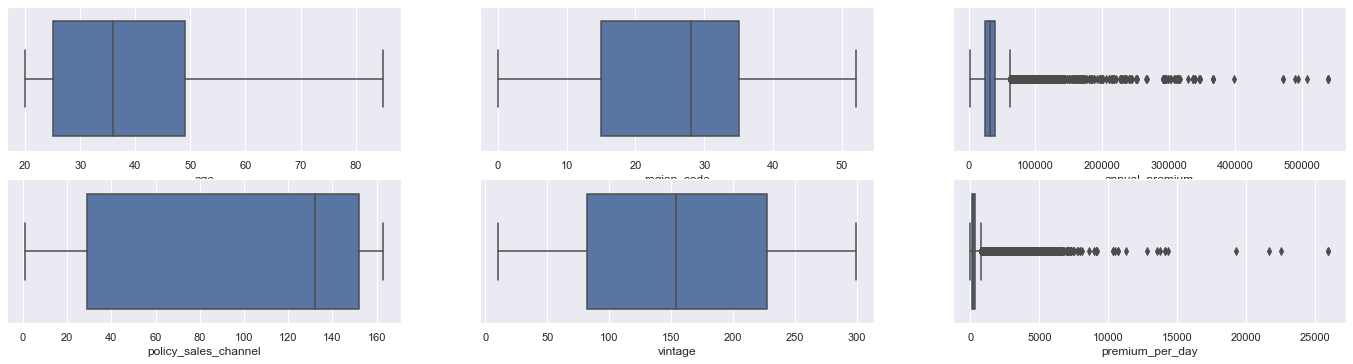

In [49]:
# Plotting boxplots to see if a variable contains outliers
# outlier = RobustScaler
# Without outliers = MinMaxScaler

plt.subplot( 3, 3, 1 )
sns.boxplot( x='age', data=df5 )

plt.subplot( 3, 3, 2 )
sns.boxplot( x='region_code', data= df5 )

plt.subplot( 3, 3, 3 )
sns.boxplot( x='annual_premium', data= df5 )

plt.subplot( 3, 3, 4 )
sns.boxplot( x='policy_sales_channel', data= df5 )

plt.subplot( 3, 3, 5 )
sns.boxplot( x='vintage', data= df5 )

plt.subplot( 3, 3, 6 )
sns.boxplot( x='premium_per_day', data= df5 )

#plt.subplot( 3, 3, 7 )
#sns.boxplot( x='people_by_region', data= df5 )
#
#plt.subplot( 3, 3, 8 )
#sns.boxplot( x='mean_annual_premium_region', data= df5 )

<AxesSubplot:ylabel='Density'>

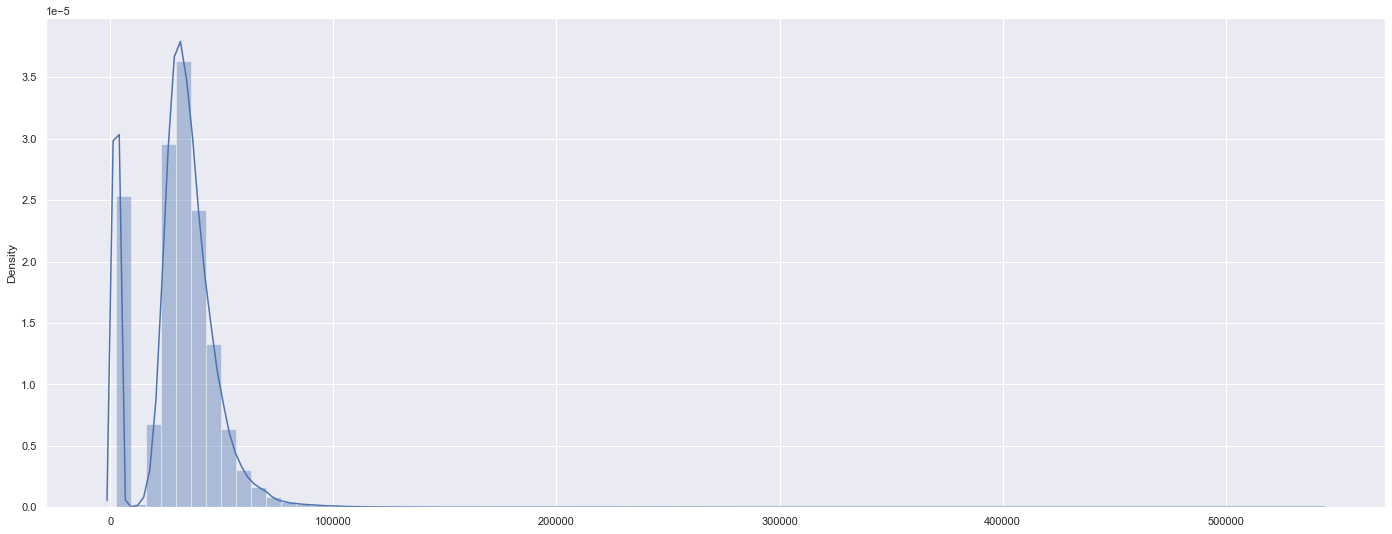

In [50]:
sns.distplot( x=df5['annual_premium'], bins=80 )

In [51]:
df5.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,risk_age,vintage_month,premium_per_day,response
1021,1022,Female,61,1,28.0,0,1-2 Year,1,54320.0,26.0,20,0,month,2716.00,0
273686,273687,Male,46,1,32.0,0,1-2 Year,1,26077.0,59.0,192,0,close to a year,135.82,0
21336,21337,Male,22,1,14.0,1,< 1 Year,0,34465.0,152.0,236,1,close to a year,146.04,0
60613,60614,Female,22,1,46.0,1,< 1 Year,0,21907.0,152.0,12,1,month,1825.58,0
343126,343127,Male,35,1,13.0,0,1-2 Year,1,37313.0,124.0,96,0,semester,388.68,0


## 5.1 Standardization

In [52]:
import pickle

In [53]:
ss = pp.StandardScaler()
# annual_premium
df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values )
pickle.dump( ss, open( '../parameter/annual_premium_scaler.pkl', 'wb' ) )

## 5.2 Rescalling

In [54]:
mms_age     = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()
rs_ppd      = pp.RobustScaler()
rs_mapr     = pp.RobustScaler()
rs_pbr      = pp.RobustScaler()

# age - MinMaxScaler
df5['age'] = mms_age.fit_transform( df5[['age']].values )
pickle.dump( mms_age, open( '../parameter/age_scaler.pkl', 'wb' ) )

# vintage - MinMaxScaler
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )
pickle.dump( mms_vintage, open( '../parameter/vintage_scaler.pkl', 'wb' ) )

# premium_per_day - RobustScaler
df5['premium_per_day'] = rs_ppd.fit_transform( df5[['premium_per_day']].values )
pickle.dump( rs_ppd, open( '../parameter/premium_per_day_scaler.pkl', 'wb' ) )

## mean_annual_premium_region
#df5['mean_annual_premium_region'] = rs_mapr.fit_transform( df5[['mean_annual_premium_region']].values )
#
## people_by_region
#df5['people_by_region'] = rs_pbr.fit_transform( df5[['people_by_region']].values )
#

## 5.3 Encoder

In [55]:
# gender - Target Encoding
target_encode_gender = df5.groupby( 'gender' )['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )
pickle.dump( target_encode_gender, open( '../parameter/gender_scaler.pkl', 'wb' ) )


# vehicle_age - One Hot Encoding
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

# region_code - Target Encoding / Frequency Encoding
target_encode_region_code = df5.groupby( 'region_code' )['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )
pickle.dump( target_encode_region_code, open( '../parameter/region_code_scaler.pkl', 'wb' ) )


# policy_sales_channel - Frequency Encoding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 ) 
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )
pickle.dump( fe_policy_sales_channel, open( '../parameter/policy_sales_channel_scaler.pkl', 'wb' ) )

# vintage_month 
vm_dict = {'month': 1, 'quarter': 2, 'semester': 3, 'close to a year': 4}
df5['vintage_month'] = df5['vintage_month'].map( vm_dict )


In [56]:
df5['vintage_month'].unique()

array([1, 4, 3, 2], dtype=int64)

In [57]:
x_validation.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,risk_age,vintage_month,premium_per_day
140111,140112,Female,30,1,30.0,1,< 1 Year,0,27285.0,152.0,97,0,semester,281.29
163215,163216,Female,40,1,28.0,0,1-2 Year,1,2630.0,26.0,215,0,close to a year,12.23
205456,205457,Female,42,1,28.0,0,1-2 Year,1,34133.0,26.0,42,0,quarter,812.69
377749,377750,Female,31,1,35.0,0,1-2 Year,1,2630.0,124.0,287,0,close to a year,9.16
73464,73465,Female,52,1,28.0,1,1-2 Year,0,40869.0,26.0,162,0,semester,252.28


In [58]:
df5.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,risk_age,vintage_month,premium_per_day,response,vehicle_age_1-2 Year,vehicle_age_< 1 Year,vehicle_age_> 2 Years
1021,1022,0.103893,0.630769,1,0.187177,0,1,1.382210,0.209530,0.034602,0,1,9.819910,0,1,0,0
273686,273687,0.138758,0.400000,1,0.081395,0,1,-0.261017,0.000361,0.629758,0,4,-0.229086,0,1,0,0
21336,21337,0.138758,0.030769,1,0.089690,1,0,0.227011,0.353767,0.782007,1,4,-0.189282,0,0,1,0
60613,60614,0.103893,0.030769,1,0.102491,1,0,-0.503635,0.353767,0.006920,1,1,6.352002,0,0,1,0
343126,343127,0.138758,0.230769,1,0.089391,0,1,0.392713,0.193990,0.297578,0,3,0.755725,0,1,0,0


## 5.4 Validation Preparation

In [59]:
# gender
x_validation.loc[:, 'gender'] =  x_validation.loc[:, 'gender'].map( target_encode_gender )

# age
x_validation.loc[:, 'age'] = mms_age.transform( x_validation[['age']].values )

# region_code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map( target_encode_region_code )

# vehicle_age
x_validation = pd.get_dummies( x_validation, prefix='vehicle_age', columns=['vehicle_age'] )


# annual_premium
x_validation.loc[:, 'annual_premium'] = ss.transform( x_validation[['annual_premium']].values )

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map( fe_policy_sales_channel )

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.transform( x_validation[['vintage']].values )

# premium_per_day
x_validation.loc[:, 'premium_per_day'] = rs_ppd.fit_transform( x_validation[['premium_per_day']].values ) 

# vintage_month 
vm_dict = {'month': 1, 'quarter': 2, 'semester': 3, 'close to a year': 4}
x_validation['vintage_month'] = x_validation['vintage_month'].map( vm_dict )

# fillna
x_validation = x_validation.fillna( 0 )

## mean_annual_premium_region
#x_validation.loc[:, 'mean_annual_premium_region'] = rs_mapr.fit_transform( df5[['mean_annual_premium_region']].values )
#
## people_by_region
#x_validation.loc[:, 'people_by_region'] = rs_pbr.fit_transform( df5[['people_by_region']].values )



In [60]:
x_validation.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,risk_age,vintage_month,premium_per_day,vehicle_age_1-2 Year,vehicle_age_< 1 Year,vehicle_age_> 2 Years
140111,140112,0.103893,0.153846,1,0.075925,1,0,-0.190734,0.353767,0.301038,0,3,0.334805,0,1,0
163215,163216,0.103893,0.307692,1,0.187177,0,1,-1.625205,0.209530,0.709343,0,4,-0.711511,1,0,0
205456,205457,0.103893,0.338462,1,0.187177,0,1,0.207695,0.209530,0.110727,0,2,2.401303,1,0,0
377749,377750,0.103893,0.169231,1,0.127137,0,1,-1.625205,0.193990,0.958478,0,4,-0.723449,1,0,0
73464,73465,0.103893,0.492308,1,0.187177,1,0,0.599607,0.209530,0.525952,0,3,0.221991,1,0,0


In [61]:
x_validation.isna().sum()

id                       0
gender                   0
age                      0
driving_license          0
region_code              0
previously_insured       0
vehicle_damage           0
annual_premium           0
policy_sales_channel     0
vintage                  0
risk_age                 0
vintage_month            0
premium_per_day          0
vehicle_age_1-2 Year     0
vehicle_age_< 1 Year     0
vehicle_age_> 2 Years    0
dtype: int64

# 6.0 FEATURE SELECTION

## 6.1 Boruta Algorithm 

In [62]:
x_train_n = df5.drop( ['id', 'response'], axis=1 ).values
y_train_n = y_train.values.ravel()

# Define model
et = en.ExtraTreesClassifier( n_jobs=-1 )

# Define boruta
#boruta = bt.BorutaPy( et, n_estimators='auto', verbose=2, random_state=42 ).fit( x_train_n, y_train_n  )

In [63]:
cols_selected = boruta.support_.tolist()

# best features
x_train_fs = df5.drop( ['id', 'response'], axis=1 )
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( x_train_fs.columns, cols_selected_boruta ) )

NameError: name 'boruta' is not defined

In [64]:
cols_selected_boruta

NameError: name 'cols_selected_boruta' is not defined

## 6.2 Feature importance

In [65]:
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
x_train_n = df5.drop( ['id', 'response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                 feature  importance
0        premium_per_day    0.190570
0                vintage    0.175992
0         annual_premium    0.159389
0                    age    0.150470
0            region_code    0.095642
0         vehicle_damage    0.069073
0   policy_sales_channel    0.061616
0     previously_insured    0.052755
0   vehicle_age_< 1 Year    0.011945
0          vintage_month    0.009184
0               risk_age    0.008295
0                 gender    0.006836
0   vehicle_age_1-2 Year    0.005439
0  vehicle_age_> 2 Years    0.002266
0        driving_license    0.000529


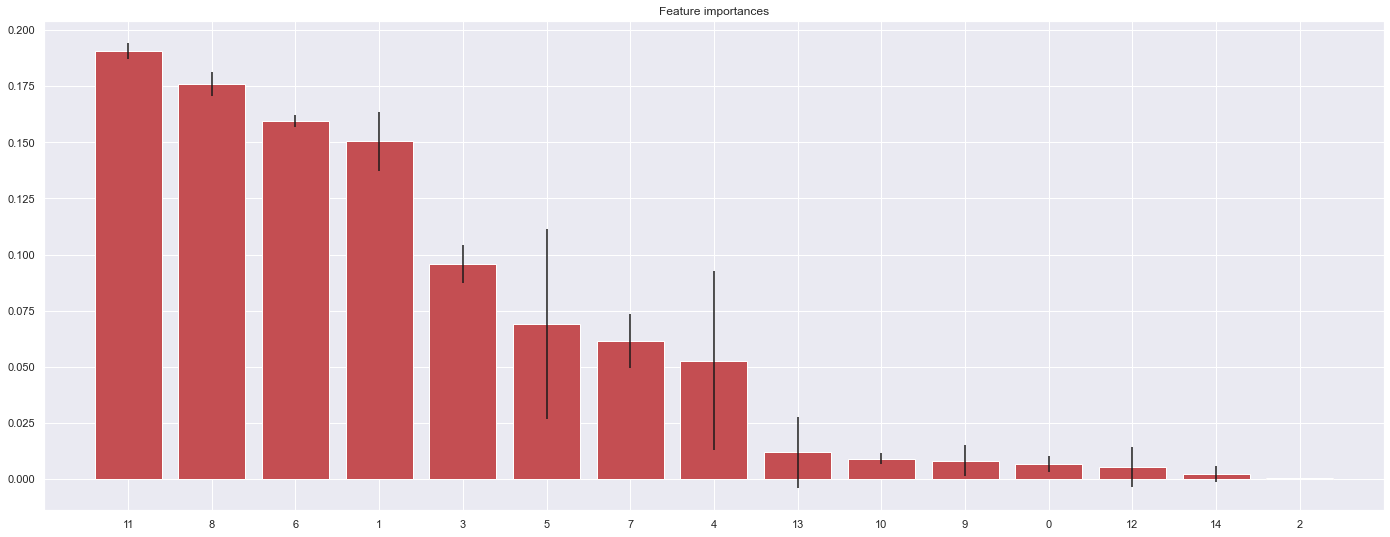

In [66]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# 7.0 MACHINE LEARNING MODELLING

In [67]:
cols_selected = [ 'premium_per_day', 'vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured' ]

In [68]:
x_train = df5[cols_selected]

x_val = x_validation[cols_selected]
y_val = y_validation

In [69]:
x_train.head()

,premium_per_day,vintage,annual_premium,age,region_code,vehicle_damage,policy_sales_channel,previously_insured
1021,9.819910,0.034602,1.382210,0.630769,0.187177,1,0.209530,0
273686,-0.229086,0.629758,-0.261017,0.400000,0.081395,1,0.000361,0
21336,-0.189282,0.782007,0.227011,0.030769,0.089690,0,0.353767,1
60613,6.352002,0.006920,-0.503635,0.030769,0.102491,0,0.353767,1
343126,0.755725,0.297578,0.392713,0.230769,0.089391,1,0.193990,0


## 7.1 Target Variable Resampling

### 7.1.1 SMOTE + Tomek Links

In [70]:
print('Before ressampling')
y_train.value_counts()

Before ressampling


0    267454
1     37433
Name: response, dtype: int64

In [71]:
#resample
x_train, y_train = SMOTETomek( random_state = 42 ).fit_resample( x_train, y_train )

In [72]:
print('After ressampling')
y_train.value_counts()

After ressampling


0    262649
1    262649
Name: response, dtype: int64

## 7.1 KNN Classifier

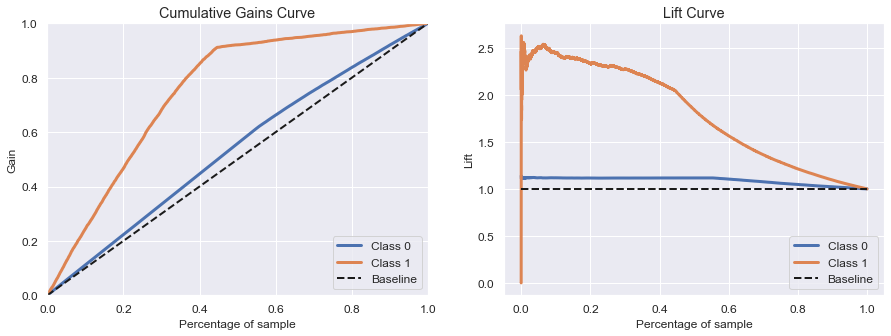

In [73]:
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=7 )

# model training
knn_model.fit( x_train, y_train )

# model prediction
yhat_knn = knn_model.predict_proba( x_val )

# subplot
fig, axs = plt.subplots(ncols = 2, figsize = (15,5))

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn, ax= axs[0] );

# Lift Curve
skplt.metrics.plot_lift_curve( y_val, yhat_knn, ax= axs[1] );

## 7.2 Logistic Regression

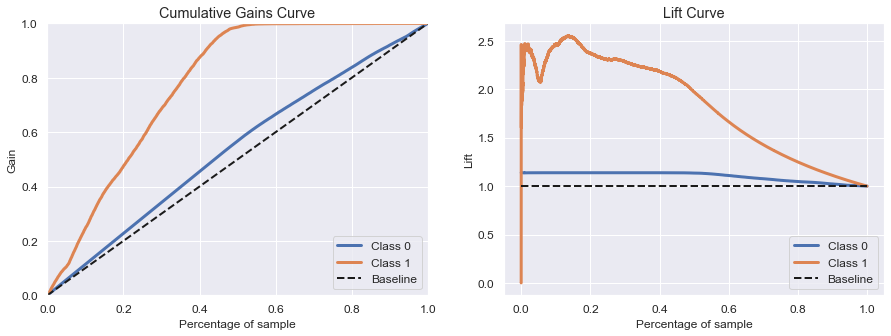

In [74]:
# model definition
lr_model = lm.LogisticRegression()
# model training
lr_model.fit( x_train, y_train )
# model prediction
yhat_lr = lr_model.predict_proba( x_val )

# subplot
fig, axs = plt.subplots(ncols = 2, figsize = (15,5))

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr, ax= axs[0] );

# Lift Curve
skplt.metrics.plot_lift_curve( y_val, yhat_lr,ax= axs[1] );

## 7.3 Random Forest

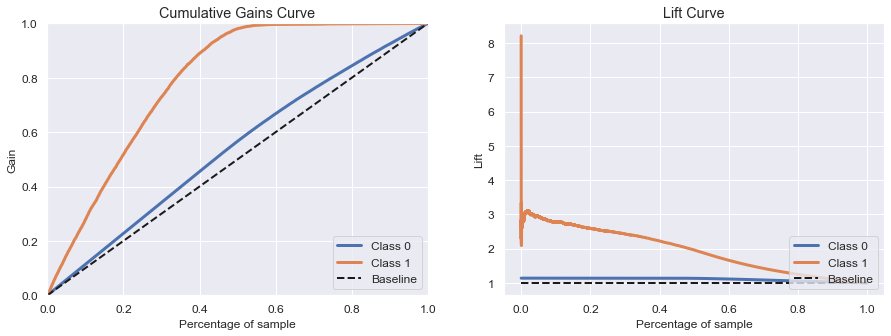

In [75]:
# model definition
model_rf = en.RandomForestClassifier()

# model Training
model_rf.fit( x_train, y_train )

# model predicition
yhat_rf = model_rf.predict_proba( x_val )


# subplot
fig, axs = plt.subplots( ncols = 2, figsize = (15,5) )

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_rf, ax = axs[0] );

# Lift Curve
skplt.metrics.plot_lift_curve( y_val, yhat_rf, ax = axs[1] );

## 7.4 XGBoost

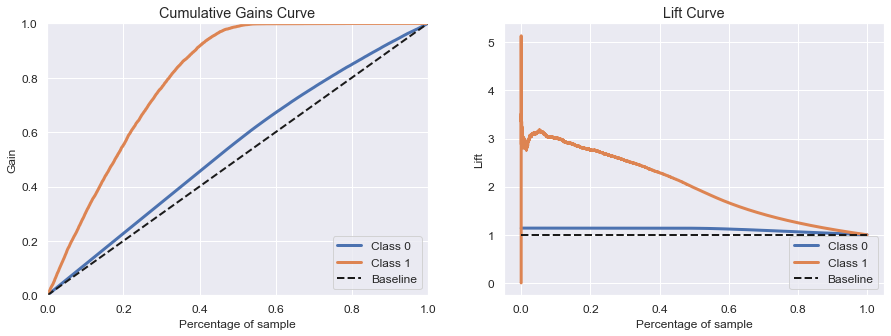

In [75]:
# model definition
model_xgb = xgb.XGBClassifier()

# model training
model_xgb.fit( x_train, y_train )

# model performance
yhat_xgb = model_xgb.predict_proba( x_val )

# subplot
fig, axs = plt.subplots( ncols = 2, figsize = (15,5) )

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_xgb, ax = axs[0] );

# Lift Curve
skplt.metrics.plot_lift_curve( y_val, yhat_xgb, ax = axs[1] );

## 7.5 LGBM

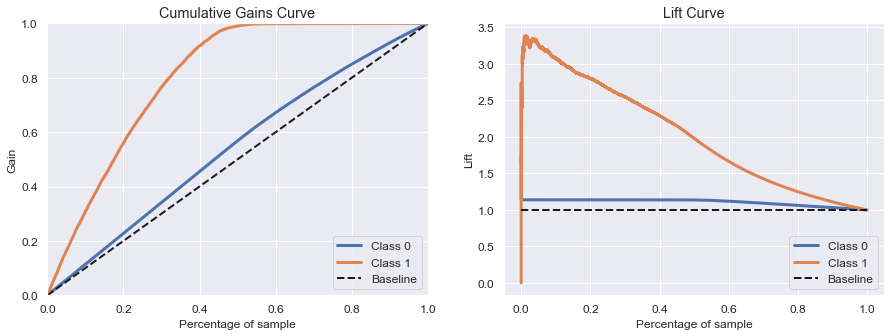

In [77]:
# model definition
model_lgbm = LGBMClassifier()

# model Training
model_lgbm.fit( x_train, y_train )

# model performance
yhat_lgbm = model_lgbm.predict_proba( x_val )

fig, axs = plt.subplots(ncols = 2, figsize = (15,5))
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lgbm, ax= axs[0] );

# Lift Curve
skplt.metrics.plot_lift_curve( y_val, yhat_lgbm, ax= axs[1] );

## 7.4 Extra Trees

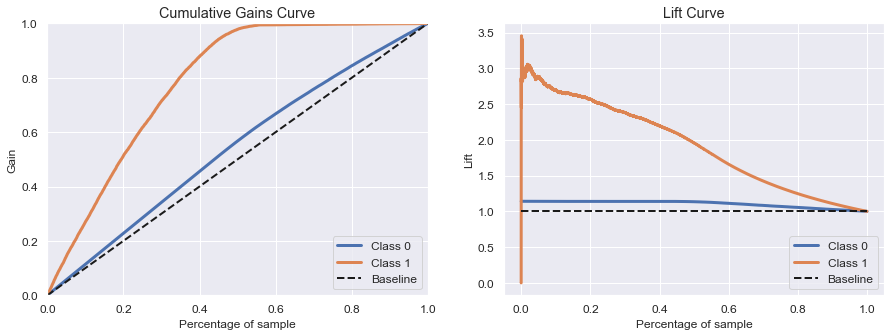

In [70]:
# model definition
model_et = en.ExtraTreesClassifier( n_estimators=100, n_jobs=-1 )

# model training
model_et.fit( x_train, y_train )

# model performance
yhat_et = model_et.predict_proba( x_val )


fig, axs = plt.subplots(ncols = 2, figsize = (15,5))
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_et, ax= axs[0]);

# Lift Curve
skplt.metrics.plot_lift_curve( y_val, yhat_et, ax= axs[1] );

# 8.0 PERFORMANCE METRICS

In [73]:
df8 = x_validation.copy()
df8['response'] = y_validation.copy()

In [72]:
df8.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,risk_age,vintage_month,premium_per_day,vehicle_age_1-2 Year,vehicle_age_< 1 Year,vehicle_age_> 2 Years,response
95223,95224,0.138111,0.030769,1,0.095786,0,1,0.356106,0.193564,0.775087,1,4,-0.147863,1,0,0,1
66479,66480,0.103766,0.153846,1,0.120413,1,0,0.027399,0.028053,0.083045,0,2,2.808613,0,1,0,0
86560,86561,0.103766,0.307692,1,0.095786,0,1,0.298775,0.209035,0.823529,0,4,-0.197985,1,0,0,0
74499,74500,0.103766,0.107692,1,0.081679,0,1,-0.266606,0.354262,0.840830,0,4,-0.358906,0,1,0,0
125432,125433,0.103766,0.076923,1,0.072772,1,0,-0.334668,0.354262,0.034602,0,1,4.093558,0,1,0,0


In [81]:
xgb_val  = cross_validation( model_xgb, x_train, y_train, 5, df8, Verbose = False )
lr_val   = cross_validation( lr_model, x_train, y_train, 5, df8, Verbose = False )
knn_val  = cross_validation( knn_model, x_train, y_train, 5, df8, Verbose = False )
rf_val   = cross_validation( model_rf, x_train, y_train, 5, df8, Verbose = False )
et_val   = cross_validation( model_et, x_train, y_train, 5, df8, Verbose = False )
lgbm_val = cross_validation( model_lgbm, x_train, y_train, 5, df8, Verbose = False )

In [82]:
results = pd.concat([xgb_val, lr_val, knn_val, rf_val, et_val, lgbm_val])
results.sort_values(by = 'Recall Mean', ascending = False)

,Model Name,Accuracy Mean,Precision Mean,Precision STD,Recall Mean,Recall STD,Precision@K Mean,Precision@K STD,Recall@K Mean,Recall@K STD
0,LogisticRegression,0.7890,0.7097,0.0007,0.9781,0.0003,0.7562,0.0029,0.2879,0.0011
0,KNeighborsClassifier,0.8609,0.7930,0.0017,0.9769,0.0005,0.9189,0.0059,0.3499,0.0022
0,ExtraTreesClassifier,0.9279,0.8999,0.0008,0.9630,0.0010,0.9981,0.0001,0.3800,0.0000
0,XGBClassifier,0.8428,0.7833,0.0012,0.9478,0.0012,0.9918,0.0016,0.3776,0.0006
0,RandomForestClassifier,0.9222,0.9102,0.0012,0.9367,0.0009,0.9998,0.0000,0.3807,0.0000
0,LGBMClassifier,0.9015,0.9103,0.0021,0.8907,0.0026,1.0000,0.0000,0.3807,0.0000


# 9.0 HYPERPARAMETER FINE TUNING

In [73]:
import optuna

In [74]:
def objective(trial):

        random_state = 42
        n_jobs = -1
        max_depth = trial.suggest_int("max_depth", 80, 120)
        n_estimators = trial.suggest_int("n_estimators", 80, 120)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 5)
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    

        classifier_obj = en.ExtraTreesClassifier(random_state    = random_state,
                                              n_jobs             = n_jobs,
                                              max_depth          = max_depth,
                                              n_estimators       = n_estimators,
                                              min_samples_split  = min_samples_split,
                                              min_samples_leaf   = min_samples_leaf
                                              
                                             )

  
        result = cross_validation(classifier_obj, x_train, y_train, 5, df4, Verbose = False)
    
        return result['Recall Mean'][0]


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = 100)

trial = study.best_trial

print('Recall: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2021-10-24 10:19:11,788] A new study created in memory with name: no-name-174b2bfa-45f4-4a10-8f4f-8936ee99bf97
[I 2021-10-24 10:20:23,870] Trial 0 finished with value: 0.9709 and parameters: {'max_depth': 120, 'n_estimators': 99, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9709.
[I 2021-10-24 10:21:47,828] Trial 1 finished with value: 0.9702 and parameters: {'max_depth': 91, 'n_estimators': 115, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9709.
[I 2021-10-24 10:22:41,363] Trial 2 finished with value: 0.9684 and parameters: {'max_depth': 108, 'n_estimators': 92, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9709.
[I 2021-10-24 10:23:40,138] Trial 3 finished with value: 0.9703 and parameters: {'max_depth': 117, 'n_estimators': 98, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9709.
[I 2021-10-24 10:24:40,535] Trial 4 finished with value: 0.9709 and parame

[I 2021-10-24 11:00:15,081] Trial 38 finished with value: 0.9626 and parameters: {'max_depth': 91, 'n_estimators': 98, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 21 with value: 0.9711.
[I 2021-10-24 11:01:12,507] Trial 39 finished with value: 0.9702 and parameters: {'max_depth': 82, 'n_estimators': 105, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.9711.
[I 2021-10-24 11:01:53,251] Trial 40 finished with value: 0.9674 and parameters: {'max_depth': 98, 'n_estimators': 88, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 21 with value: 0.9711.
[I 2021-10-24 11:02:53,192] Trial 41 finished with value: 0.971 and parameters: {'max_depth': 102, 'n_estimators': 108, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.9711.
[I 2021-10-24 11:03:54,291] Trial 42 finished with value: 0.9709 and parameters: {'max_depth': 106, 'n_estimators': 110, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial

[I 2021-10-24 11:41:17,633] Trial 76 finished with value: 0.9709 and parameters: {'max_depth': 113, 'n_estimators': 110, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.9711.
[I 2021-10-24 11:42:20,484] Trial 77 finished with value: 0.9709 and parameters: {'max_depth': 108, 'n_estimators': 105, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.9711.
[I 2021-10-24 11:43:18,979] Trial 78 finished with value: 0.9689 and parameters: {'max_depth': 107, 'n_estimators': 108, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.9711.
[I 2021-10-24 11:44:35,734] Trial 79 finished with value: 0.9623 and parameters: {'max_depth': 104, 'n_estimators': 99, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 21 with value: 0.9711.
[I 2021-10-24 11:45:37,575] Trial 80 finished with value: 0.9709 and parameters: {'max_depth': 118, 'n_estimators': 104, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is 

Recall: 0.9711
Best hyperparameters: {'max_depth': 99, 'n_estimators': 106, 'min_samples_split': 4, 'min_samples_leaf': 2}


Recall: 0.9711


Best hyperparameters: {'max_depth': 99, 'n_estimators': 106, 'min_samples_split': 4, 'min_samples_leaf': 2}

In [74]:
def objective(trial):

        random_state = 42
        n_jobs = -1
        max_depth = trial.suggest_int("max_depth", 80, 120)
        n_estimators = trial.suggest_int("n_estimators", 80, 120)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 5)
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    

        classifier_obj = xgb.XGBClassifier(   random_state       = random_state,
                                              n_jobs             = n_jobs,
                                              max_depth          = max_depth,
                                              n_estimators       = n_estimators,
                                              min_samples_split  = min_samples_split,
                                              min_samples_leaf   = min_samples_leaf
                                              
                                             )

  
        result = cross_validation(classifier_obj, x_train, y_train, 5, df4, Verbose = False)
    
        return result['Recall Mean'][0]


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = 100)

trial = study.best_trial

print('Recall: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2021-11-03 20:23:43,788] A new study created in memory with name: no-name-35faaeda-b164-48b9-83af-8ca508487dde


KeyboardInterrupt: 

# 10.0 FINAL MODEL

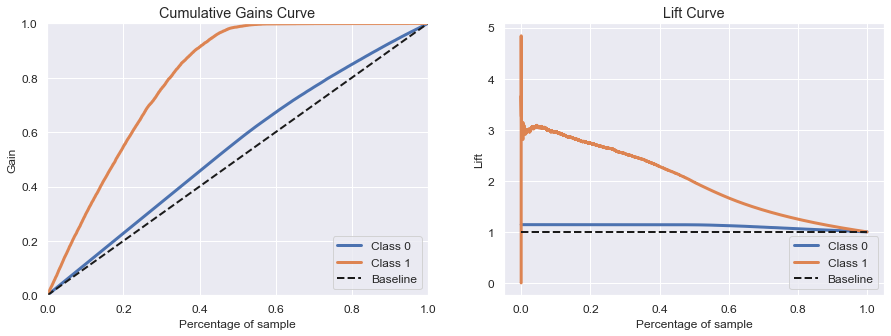

In [74]:
# model definition
model_et_tuned = en.ExtraTreesClassifier( n_estimators=106, n_jobs=-1, max_depth=99, min_samples_split=4, min_samples_leaf=2 )

# model training
model_et_tuned.fit( x_train, y_train )

# model performance
yhat_et = model_et_tuned.predict_proba( x_val )


fig, axs = plt.subplots(ncols = 2, figsize = (15,5))
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_et, ax= axs[0]);

# Lift Curve
skplt.metrics.plot_lift_curve( y_val, yhat_et, ax= axs[1] );

In [75]:
et_val = cross_validation( model_et_tuned, x_train, y_train, 5, df8, Verbose = False )
et_val

,Model Name,Accuracy Mean,Precision Mean,Precision STD,Recall Mean,Recall STD,Precision@K Mean,Precision@K STD,Recall@K Mean,Recall@K STD
0,ExtraTreesClassifier,0.8651,0.8015,0.0031,0.9706,0.0013,0.9975,0.0005,0.3797,0.0002


In [76]:
# Save Trained Model
pickle.dump( model_et_tuned, open('../models/model_health_insurance.pkl', 'wb') )

In [76]:
# Save Trained Model
pickle.dump( model_xgb, open('../models/model_xgb.pkl', 'wb') )

# 11.0 BUSINESS PERFORMANCE

In [75]:
data = x_val.copy()

data['response'] = y_val.copy()
data['score'] = yhat_et[:, 1].tolist()
data = data.sort_values('score', ascending=False)

## 11.1 20.000 Calls

By using 26% of test data, in which wold translate as 20 thousand calls by the sales team, the model would be able to identify 69% people out of the total people interested in purchasing the insurance

In [79]:
percent_of_dataset = 20000 / len( data )
recall_at_20000    = recall_at_k( data, k = 20000 )
precision_at_20000 = precision_at_k( data, k = 20000 )

print( 'Percent of Data', percent_of_dataset )
print( 'Recall at 20K', recall_at_20000 )
print( 'Precision at 20K', precision_at_20000 )

Percent of Data 0.2623914355435439
Recall at 20K 0.6904100811618966
Precision at 20K 0.3232338383080846


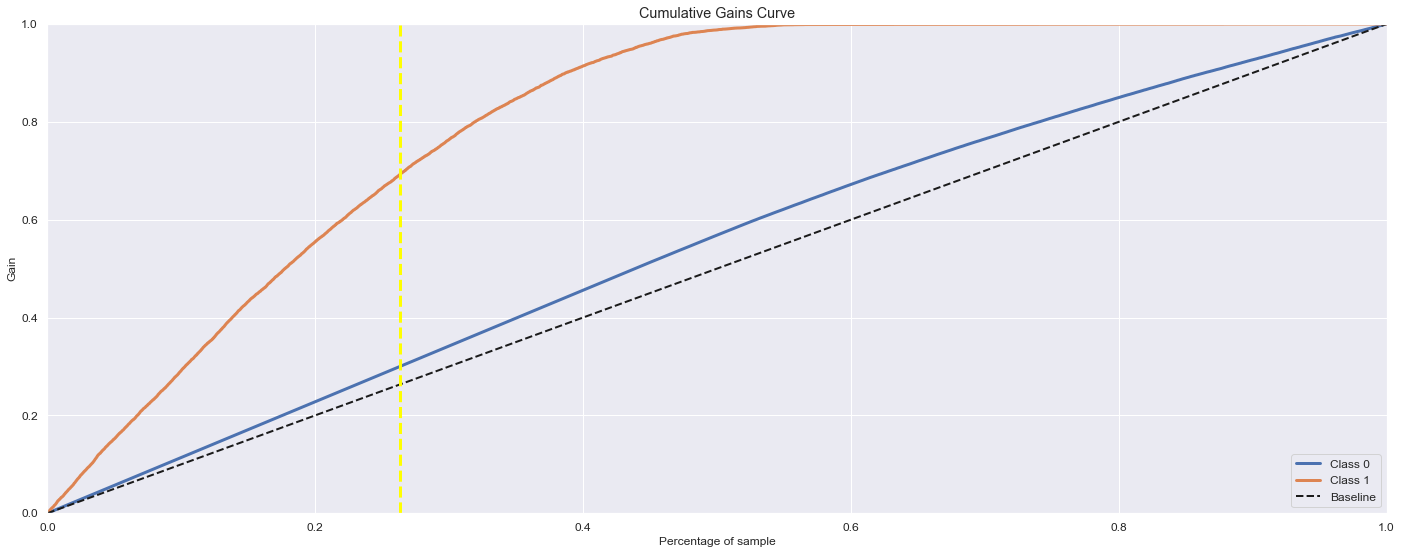

In [78]:
skplt.metrics.plot_cumulative_gain( y_val, yhat_et )
plt.axvline( percent_of_dataset, 0, 1, color='yellow', ls='--', lw=3 )
plt.show(); 

By using a little less then 33% of test data, in which wold translate as 25 thousand and 1 hundred calls by the sales team, the model would be able to identify 81% people out of the total people interested in purchasing the insurance

In [81]:
percent_of_dataset = 25100 / len( data )
recall_at_25100    = recall_at_k( data, k = 25100 )
precision_at_25100 = precision_at_k( data, k = 25100 )

print( 'Percent of Data', percent_of_dataset )
print( 'Recall at 25100K', recall_at_25100 )
print( 'Precision at 25100K', precision_at_25100 )

Percent of Data 0.3293012516071475
Recall at 25100K 0.8161042289619821
Precision at 25100K 0.30445002191147763


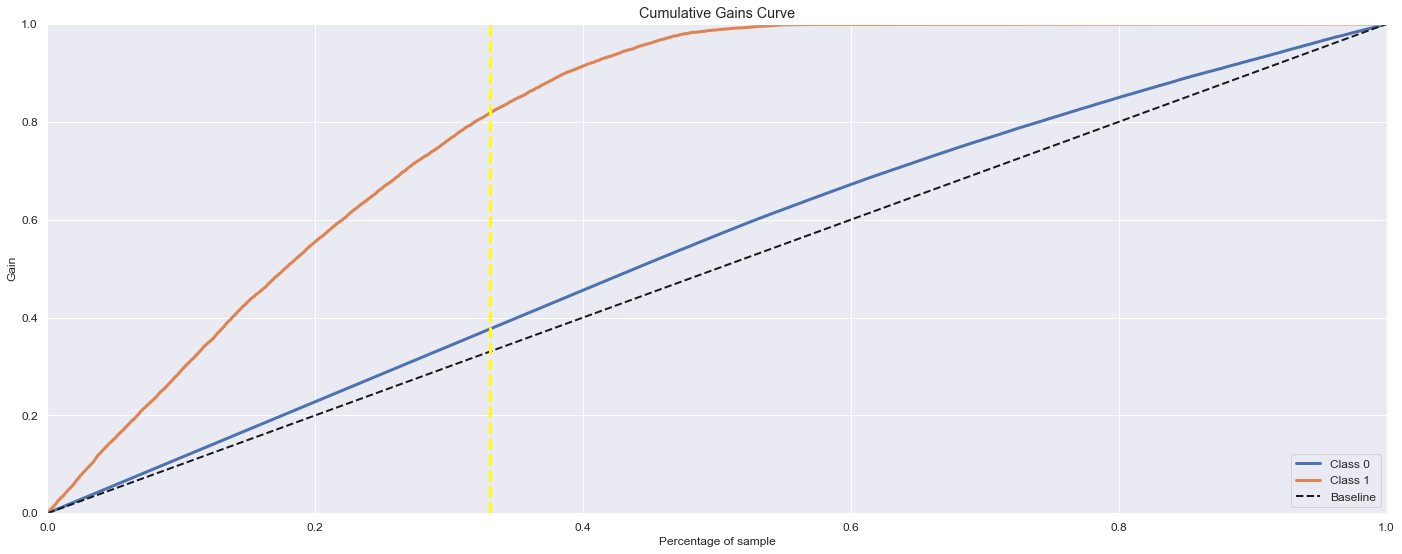

In [83]:
skplt.metrics.plot_cumulative_gain( y_val, yhat_et )
plt.axvline( percent_of_dataset, 0, 1, color='yellow', ls='--', lw=3)
plt.show(); 

 By Making 20 thousand calls, the model proposed is roughly 2,5 times better than random choice

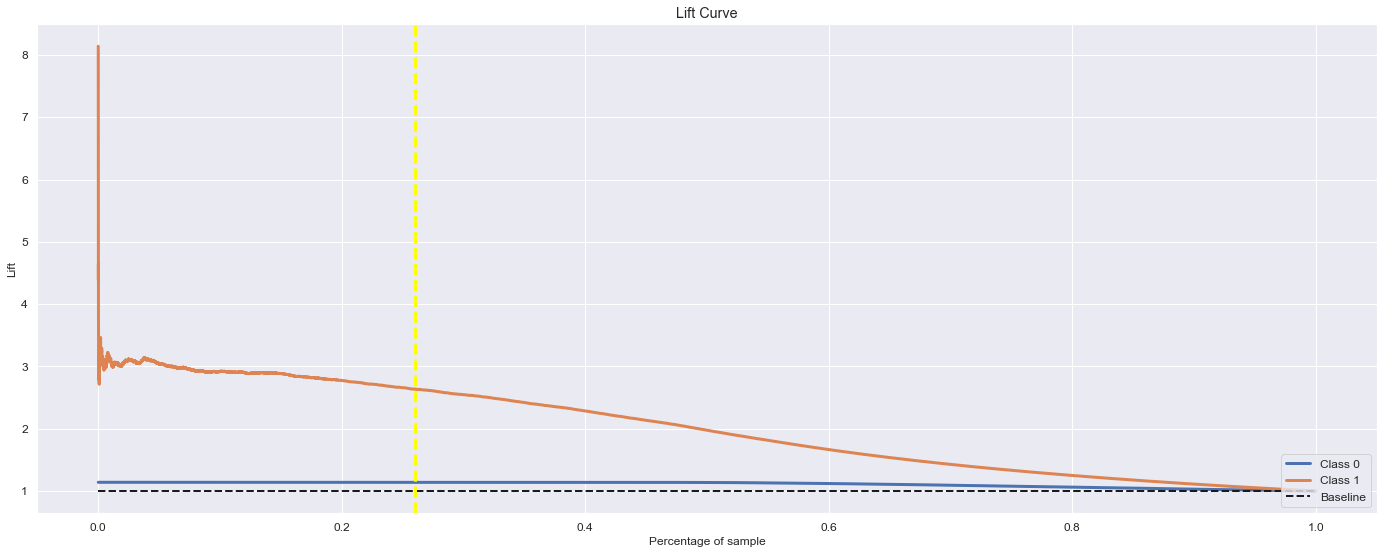

In [85]:
skplt.metrics.plot_lift_curve( y_val, yhat_et )
plt.axvline(percent_of_dataset, 0, 1, color='yellow', ls='--', lw=3);

## 10.2 40.000 Calls 

By using 52.47% of validation data, in which wold translate as 40 thousand calls by the sales team, the model would be able to identify 99.36% people out of the total people interested in purchasing the insurance.

In [87]:
percent_of_dataset = 40000 / len( data )
recall_at_40000    = recall_at_k( data, k = 40000 )
precision_at_40000 = precision_at_k( data, k=40000 )

print( 'Percent of Data: ', percent_of_dataset )
print( 'Recall at 40000: ', recall_at_40000 )
print( 'Precision at 40000: ', precision_at_40000 )

Percent of Data:  0.5247828710870878
Recall at 40000:  0.9935924818453652
Precision at 40000:  0.23259418514537136


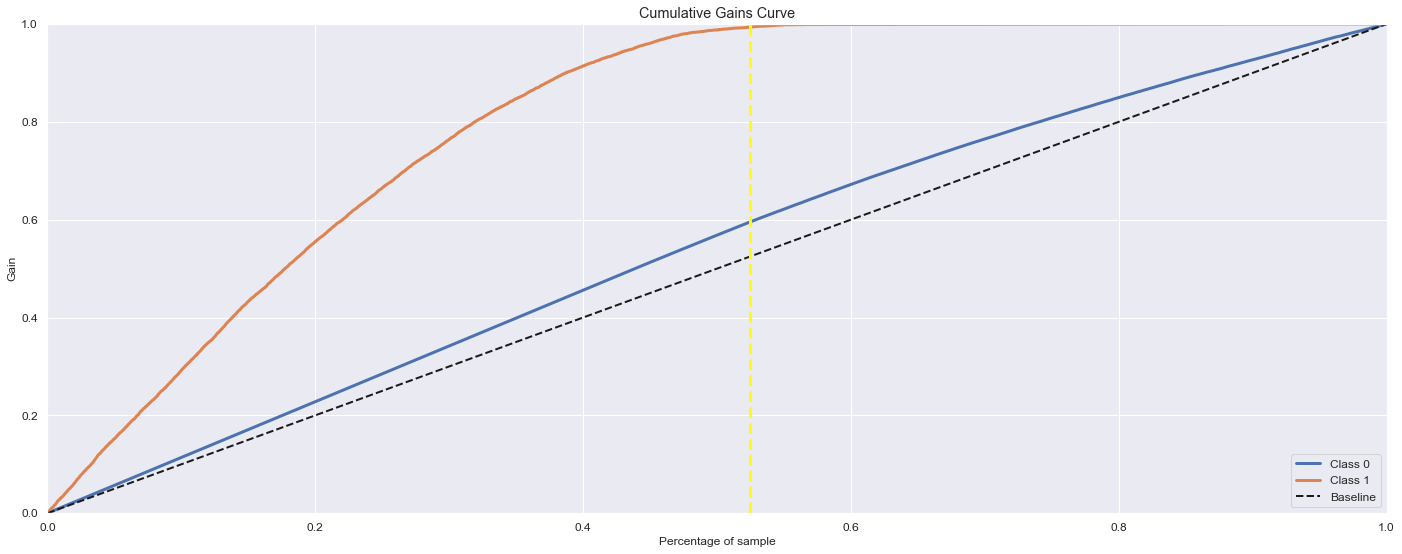

In [88]:
skplt.metrics.plot_cumulative_gain( y_val, yhat_et )
plt.axvline(percent_of_dataset, 0, 1, color='yellow', ls='--', lw=3)
plt.show(); 

  By Making 40 thousand calls, the model proposed is roughly 1,6 times better than random choice.

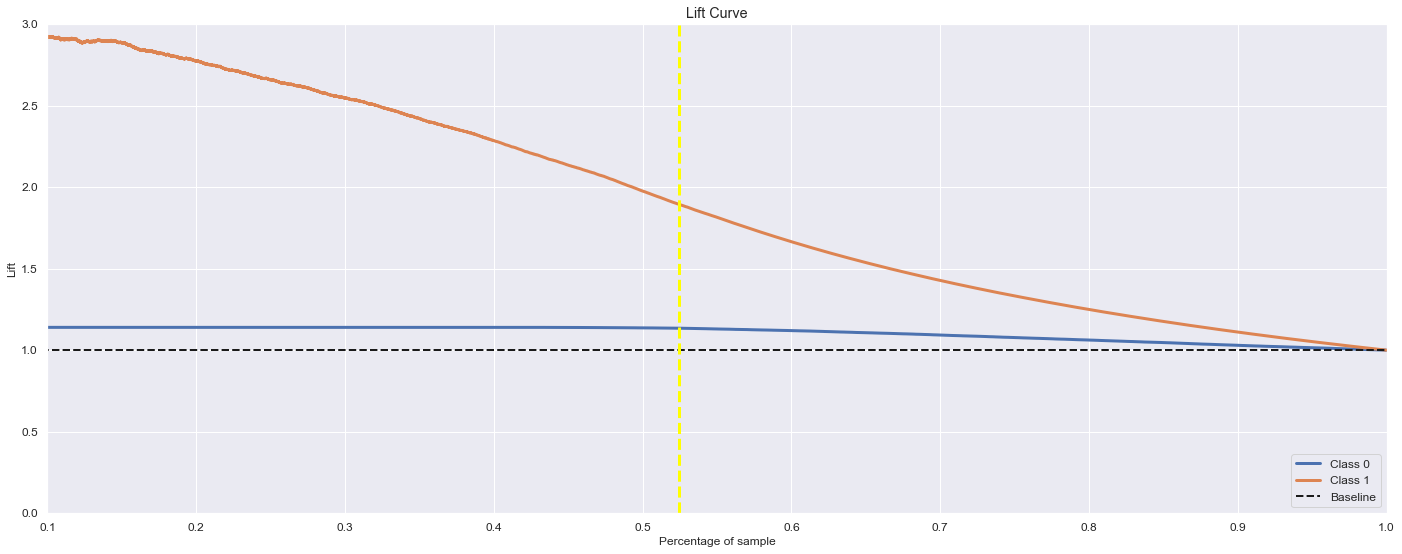

In [90]:
skplt.metrics.plot_lift_curve( y_val, yhat_et )
plt.axvline(percent_of_dataset, 0, 1, color='yellow', ls='--', lw=3);
plt.xlim(0.1,1);
plt.ylim(0,3);

Baseline model would predict 26% of all people interested in insurance by making 20 thousand calls, whereas, our model, would predict 65.5%. If each insurance is 1000 this represents a diference of 29,60 million dollars in 20 thousand calls

In [86]:
random_choice = (26/100) * len(data)
model         = (65/100) * len(data)

x = random_choice * 1000
y = model * 1000

print(str(int(x)) + ' revenue with random choice')
print(str(int(y)) + ' revenue with model')

print('difference in $: ' + str(int(y-x)) )

19817720 revenue with random choice
49544300 revenue with model
difference in $: 29726580


# 11.0 DEPLOY TO PRODUCTION

## 11.1 Health Insurance Class

In [ ]:
import pickle
import inflection
import pandas as pd

class HealthInsurance( objects ):
    
    def __init__( self ):
        self.home_path                   = r'C:\Users\Cliente\repos\pa004_cross_sell\cross-sell\parameter'
        self.annual_premium_scaler       = pickle.load( open( self.home_path + '/annual_premium_scaler.pkl', 'rb' ) )
        self.age_scaler                  = pickle.load( open( self.home_path + '/age_scaler.pkl', 'rb' ) )
        self.vintage_scaler              = pickle.load( open( self.home_path + '/vintage_scaler.pkl', 'rb' ) )
        self.premium_per_day_scaler      = pickle.load( open( self.home_path + '/premium_per_day_scaler.pkl', 'rb' ) )
        self.gender_scaler               = pickle.load( open( self.home_path + '/gender_scaler.pkl', 'rb' ) )
        self.region_code_scaler          = pickle.load( open( self.home_path + '/region_code_scaler.pkl', 'rb' ) )
        self.policy_sales_channel_scaler = pickle.load( open( self.home_path + '/policy_sales_channel_scaler.pkl', 'rb' ) )
        
        
        
    def data_cleaning( self, df1 ):  

        ## 1.1 Rename Columns

        old_columns = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
               'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
               'Policy_Sales_Channel', 'Vintage']

        snakecase = lambda x: inflection.underscore( x )

        new_columns = list( map( snakecase, old_columns ) )

        # rename
        df1.columns = new_columns
        
        return df1
    
    def feature_engineering( self, df2 ):
        ## 2.2 Feature Engineering

        # Create risk age variable
        df2['risk_age'] = df2['age'].apply( lambda x: 'Yes' if x < 25 else 'No' )

        # Vintage_month
        # Separating vintage in months
        df2['vintage_month'] = df2['vintage'].apply( lambda x: 'month' if  x <= 31 else 'quarter' if (x > 31 ) & (x <= 90) else 
                                                    'semester' if (x > 90) & (x <= 180) else 'close to a year')
        # premium_per_day (annual_premium/vintage)
        df2['premium_per_day'] = round( df2['annual_premium'] / df2['vintage'], 2 )

        return df2
       
    
    def data_preparation( self, df5 ):
        # 5.0 DATA PREPARATION

        ## 5.1 Standardization
        # annual_premium
        df5['annual_premium'] = self.annual_premium_scaler.fit_transform( df5[['annual_premium']].values )

        ## 5.2 Rescalling

        # age - MinMaxScaler
        df5['age'] = self.age_scaler.fit_transform( df5[['age']].values )
        

        # vintage - MinMaxScaler
        df5['vintage'] = self.vintage_scaler.fit_transform( df5[['vintage']].values )
       
        # premium_per_day - RobustScaler
        df5['premium_per_day'] = self.premium_per_day_scaler.fit_transform( df5[['premium_per_day']].values )        

        ## 5.3 Encoder

        # gender - Target Encoding
        
        df5.loc[:, 'gender'] = df5['gender'].map( self.gender_scaler )      


        # vehicle_age - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

        # region_code - Target Encoding / Frequency Encoding
        
        df5.loc[:, 'region_code'] = df5['region_code'].map( self.region_code_scaler )       


        # policy_sales_channel - Frequency Encoding
         
        df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( self.policy_sales_channel_scaler )        

        # vintage_month 
        vm_dict = {'month': 1, 'quarter': 2, 'semester': 3, 'close to a year': 4}
        df5['vintage_month'] = df5['vintage_month'].map( vm_dict )
                
        cols_selected = [ 'premium_per_day', 'vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured' ]
        
        return df5[ cols_selected ]
    
    
    def get_prediction (self, model, original_data, test_data):
        
        pred = model.predict_proba(test_data)
        original_data['score'] = pred[:,1].tolist()
        
        return original_data.to_json(orient = 'records', date_format = 'iso')


        

## 11.2 API Handler

In [ ]:
import pickle
import pandas as pd
from flask                           import Flask, request, Response
from healthinsurance.HealthInsurance import HealthInsurance

# loading model
model = pickle.load( open( r'C:\Users\Cliente\repos\pa004_cross_sell\cross-sell\models\model_health_insurance.pkl', 'rb' ) )

# initialize api
app = Flask( __name__ )

@app.route( '/healthinsurance/predict', methods=['POST'] )
def healthinsurance_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple examples
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instatiate HealthInsurance Class
        pipeline = HealthInsurance()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_predicition( model, test_raw, df3 )
        
        return df_response
    
    
    else:
        return Response( '{}', status=200, mimetype='application/json' )




if __name__ == '__main__':
    port = os.environ.get( 'PORT', 5000 )
    app.run( '0.0.0.0', port=port, debug=True )